In [1]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
from scipy.interpolate import interp1d
#import mse
from sklearn.metrics import mean_squared_error
from scipy.signal import medfilt


In [2]:
participant_list = [6,7,8,9,10,11,28,29,44,45,50,51,52,53,64,65,76,77,78,79,80,81,82,83]

In [5]:
#to get average duration of the videos 
import os
import moviepy
from moviepy.editor import VideoFileClip
import numpy as np

# Set the root directory to search for videos
root_directory = "../[Study Data]/used_corae/"

# Initialize a list to store the durations of videos
durations = []

# Loop through all subdirectories and find videos without "merged" in their names
for subdir, dirs, files in os.walk(root_directory):
    for file in files:
        # Check if file is an mp4 video and does not contain "merged" in its name
        if file.endswith(".mov") and "merged" not in file:
            # Get the full path to the video file
            video_path = os.path.join(subdir, file)
            # Load the video file using moviepy
            video = VideoFileClip(video_path)
            # Get the duration of the video in seconds
            duration = video.duration
            # Add the duration to the list of durations
            durations.append(duration)
            # Close the video file
            video.close()

# Calculate the average and standard deviation of the durations
avg_duration = np.mean(durations)
std_duration = np.std(durations)

# Print the average and standard deviation of the durations
print(f"Average video duration: {avg_duration:.2f} seconds")
print(f"Standard deviation of video duration: {std_duration:.2f} seconds")
#print total number of videos and of durations (sum of durations)
print(f"Total number of videos: {len(durations)}")
print(f"Total number of durations: {sum(durations)}")

Average video duration: 560.01 seconds
Standard deviation of video duration: 111.39 seconds
Total number of videos: 24
Total number of durations: 13440.22


# CORAE DATA

In [ ]:
#one by one, open json files in a folder, read them and add them to pandas dataframe as two columns: 'time' and 'value'

#see files in folder
filelist = os.listdir('../[Study Data]/ParticipantsJSON')
filelist = [file for file in filelist if file.endswith('.json')]

#make empty dataframe
df = pd.DataFrame(columns=['participant_number','session','timestamp', 'frame_number','frame_seconds','seconds', 'value'], index=(range(len(participant_list))))
dfrow = 0
#open files one by one and read
for file in filelist:
    pnumber = int(file[:2])
    print(pnumber)
    if pnumber in participant_list:
        
        #session number, knowing it started at 0 and it's 2 participants per session (p number start at 0)
        session = np.ceil((pnumber-1)/2)

        # Opening JSON file
        f = open('../[Study Data]/ParticipantsJSON/' + file)
        
        # returns JSON object as 
        # a dictionary
        data = json.load(f)
        #print(data)
    
        #adding to pandas df, one column for time==keys and one for values, but a single row
        #get dictionary keys
        keys = list(data.keys())
        #get dictionary values
        values_list = list(data.values())
        print(len(keys))
        values = []
        #turn every value into an int
        for value in values_list:
            value = int(value)
            values.append(value)
            
        if keys[0] == "ID":
            keys = keys[1:]
            values = values[1:]
        frames = []
        seconds = []
        frameseconds = []
        for keyf in keys:
            #split keyf according to ":"
            keyf = keyf.split(":")
            #get frames (last)
            frames.append(int(keyf[-1]))
            frameseconds.append(int(keyf[-1])/30)
            #get seconds (second to last all the way to the first)
            seconds.append(int(keyf[-2]) + 60 * int(keyf[-3]) + 3600 * int(keyf[-4]))

            
        #place in df
        df.loc[dfrow] = [pnumber,session, keys, frames,frameseconds,seconds,values]
        dfrow += 1

        # Closing file
        f.close()

df = df.sort_values(by=['participant_number'])
df.index = range(len(df))
#save df as csv
df.to_csv('./dataframes/participant_json.csv', index=False)
df

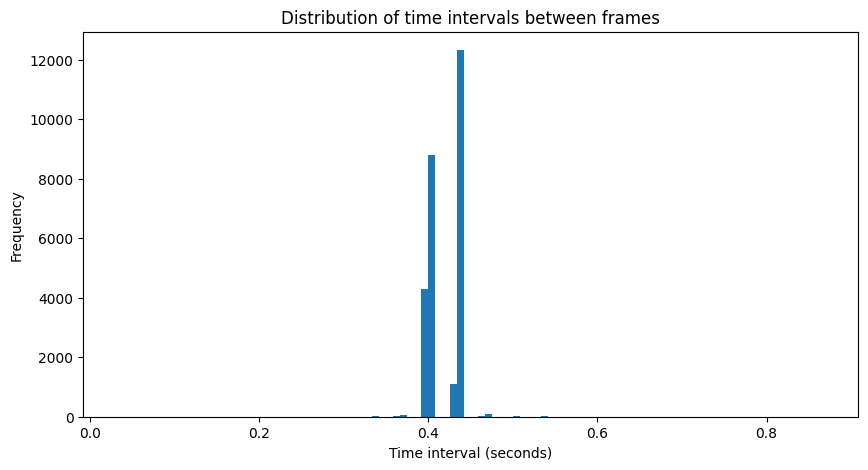

Average time interval between frames:  0.41694127903356376
Median time interval between frames:  0.4333333333332803
Standard deviation of time interval between frames:  0.01916477714318645
Number of datapoints:  26765
Average datapoints per participant:  1116.2083333333333
Median datapoints per participant:  1219.0
Standard deviation of datapoints per participant:  221.9620799383434


In [6]:
#explore granularity of the results by looking at frame_seconds per participant (time intervals)

datapoints = []
intervals = []

for ind, row in df.iterrows():
    timestamps = df['frame_seconds'][ind]
    #see interval between timestamps
    
    for i in range(len(timestamps)-1):
        intervals.append(timestamps[i+1]-timestamps[i])
    
    datapoints.append(len(timestamps))


#plot
plt.figure(figsize=(10,5))
plt.hist(intervals, bins=100)
plt.title('Distribution of time intervals between frames')
plt.xlabel('Time interval (seconds)')
plt.ylabel('Frequency')
plt.show()

#print
print('Average time interval between frames: ', np.mean(intervals))
print('Median time interval between frames: ', np.median(intervals))
print('Standard deviation of time interval between frames: ', np.std(intervals))
print('Number of datapoints: ', len(intervals))

#average datapoints per participant
print('Average datapoints per participant: ', np.mean(datapoints))
print('Median datapoints per participant: ', np.median(datapoints))
print('Standard deviation of datapoints per participant: ', np.std(datapoints))





Participant  6  has range of values:  8
Participant  6  has average of values:  1.3620564808110065
Participant  7  has range of values:  5
Participant  7  has average of values:  5.970268310369833
Participant  8  has range of values:  1
Participant  8  has average of values:  0.1686838124054463
Participant  9  has range of values:  4
Participant  9  has average of values:  0.06202723146747353
Participant  10  has range of values:  7
Participant  10  has average of values:  5.3119810201660735
Participant  11  has range of values:  9
Participant  11  has average of values:  3.0616686819830714
Participant  28  has range of values:  6
Participant  28  has average of values:  6.687683284457478
Participant  29  has range of values:  7
Participant  29  has average of values:  6.463343108504398
Participant  44  has range of values:  5
Participant  44  has average of values:  0.28791565287915655
Participant  45  has range of values:  10
Participant  45  has average of values:  -0.15883306320907

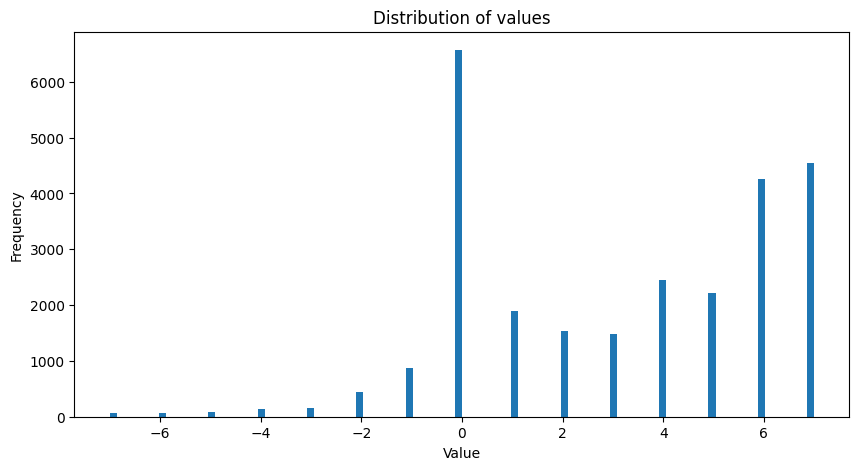

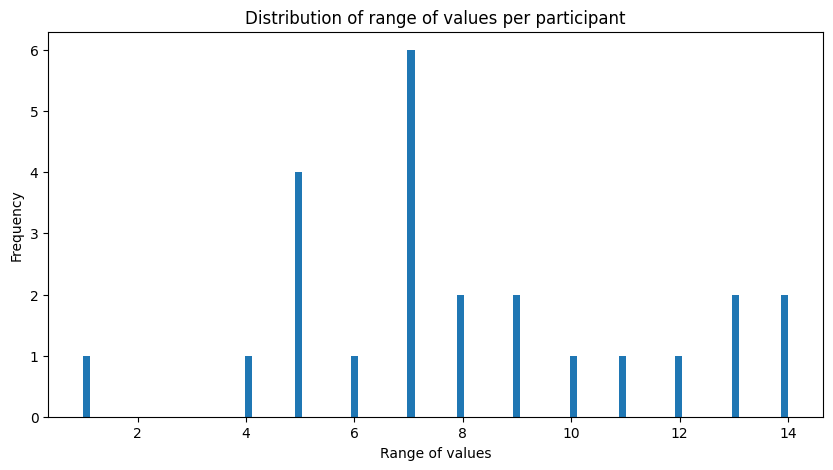

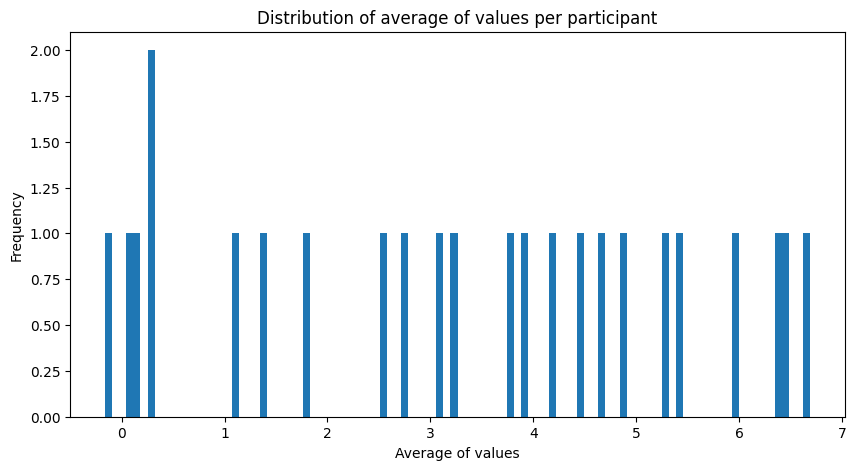

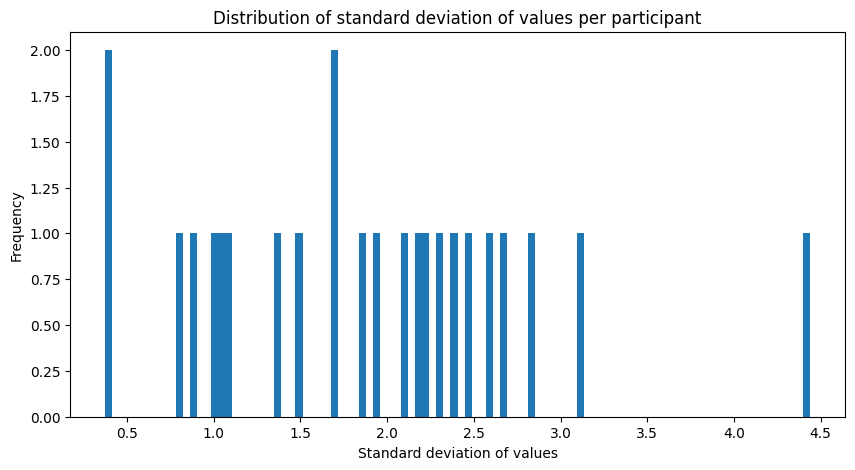

In [7]:
#now, the same for values

datapoints = []
value_range_pp = []
value_avg_pp = []
value_std_pp = []

for ind, row in df.iterrows():

    values = df['value'][ind]
    #see range of values
    value_range_pp.append(max(values)-min(values))
    value_avg_pp.append(np.mean(values))
    value_std_pp.append(np.std(values))
    datapoints.extend(values)

    print('Participant ', df['participant_number'][ind], ' has range of values: ', max(values)-min(values))
    print('Participant ', df['participant_number'][ind], ' has average of values: ', np.mean(values))
#print average value overall
print('Average value overall: ', np.mean(datapoints))
print('Median value overall: ', np.median(datapoints))
print('Standard deviation of value overall: ', np.std(datapoints))
print('Range of value overall: ', max(datapoints)-min(datapoints))
print('Average range of values per participant: ', np.mean(value_range_pp))
print('Median range of values per participant: ', np.median(value_range_pp))
print('Standard deviation of range of values per participant: ', np.std(value_range_pp))


#plot
plt.figure(figsize=(10,5))
plt.hist(datapoints, bins=100)
plt.title('Distribution of values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

#plot range of values per participant
plt.figure(figsize=(10,5))
plt.hist(value_range_pp, bins=100)
plt.title('Distribution of range of values per participant')
plt.xlabel('Range of values')
plt.ylabel('Frequency')
plt.show()

#plot average of values per participant
plt.figure(figsize=(10,5))
plt.hist(value_avg_pp, bins=100)
plt.title('Distribution of average of values per participant')
plt.xlabel('Average of values')
plt.ylabel('Frequency')
plt.show()

#plot standard deviation of values per participant
plt.figure(figsize=(10,5))
plt.hist(value_std_pp, bins=100)
plt.title('Distribution of standard deviation of values per participant')
plt.xlabel('Standard deviation of values')
plt.ylabel('Frequency')
plt.show()

In [9]:
#for each session, calculate degree of disagreement between participants with a scale of 0.1 seconds

#create new df with columns: session, participant, frame_seconds, value
df_interp = pd.DataFrame(columns=['session','participant_number','frame_seconds','value'], index=range(len(df)))

#first, get session df
sessions = df['session'].unique()
for session in sessions:
    df_session = df[df['session']==session]
    #get all participants
    participants = df_session['participant_number'].unique()
    #per participant, get all frame_seconds
    for participant in participants:
        df_p = df_session[df_session['participant_number']==participant]
  
        frame_seconds = df_p['frame_seconds'].values[0]
        values = df_p['value'].values[0]
        #now, interpolate both arrays to have the frames_seconds as the same at a 0.1 second interval
        #get min and max frame_seconds
        min_frame_seconds = min(frame_seconds)
        max_frame_seconds = np.round(max(frame_seconds),1) 
        
        #create new frame_seconds array
        new_frame_seconds = np.arange(0.0,max_frame_seconds,0.1)
        
        #interpolate values (step interpolation)
        #Create the interpolation function
        f = interp1d(frame_seconds, values, kind='next',fill_value='extrapolate')
        # Use the interpolation function to get the corresponding y-values
        new_values = f(new_frame_seconds)

        #print('new_session')
        #print(len(new_frame_seconds),len(new_values))
        #print(len(frame_seconds),len(values))
        
        #add to new df
        df_interp.loc[df_p.index] = [session,participant,new_frame_seconds,new_values]

    #print(df_interp.head())

    #just to check interpolation:
    ##plot for one partipant, then plot the other in the session
    #plt.figure(figsize=(10,5))
    ##plot from values in df_interp
    #for p in [participant -1, participant]:
    #    df_p = df_interp[df_interp['participant_number']==p]
    #    x = np.array(df_p['frame_seconds'].values[0])
    #    y = np.array(df_p['value'].values[0])
    #    plt.plot(x,y,label = 'Participant ' + str(p))
    #    #also plot the original values
    #    df_p = df_session[df_session['participant_number']==p]
    #    x = np.array(df_p['frame_seconds'].values[0])
    #    y = np.array(df_p['value'].values[0])
    #    plt.plot(x,y,label = 'Participant ' + str(p) + ' original')

    #plt.title('Session ' + str(session))
    #plt.legend()
    #plt.xlabel('Frame seconds')
    #plt.ylabel('Value')
    #plt.show()

deltas = []
cumsums = []
deltacumsum = []
    
#go back to df_interp, session by session, and make the frames_seconds be the same for all participants (equal to the max length of the frames_seconds array)
#and then extrapolate the values as per the last value
sessions = df_interp['session'].unique()
for session in sessions:
    df_session = df_interp[df_interp['session']==session]
    
    #get max length of frames_seconds
    max_length = max([len(x) for x in df_session['frame_seconds'].values])
    max_time = max([max(x) for x in df_session['frame_seconds'].values])
    min_time = min([min(x) for x in df_session['frame_seconds'].values])
   
    #get all participants
    participants = df_session['participant_number'].unique()
    #per participant, get all frame_seconds
    for participant in participants:
        old_frame = df_session[df_session['participant_number']==participant]['frame_seconds'].values[0]
        old_values = df_session[df_session['participant_number']==participant]['value'].values[0]
        #create new frame_seconds array
        new_frame_seconds = np.arange(0.0,max_time+0.1,0.1)[:max_length]
        #print('participant 1 ', max_time, np.array_equal(new_frame_seconds,old_frame))
        #if needed, extend old_values to have the same length as new_frame_seconds, by the last value
        if len(old_frame) < max_length:
            old_values = np.append(old_values,[old_values[-1]]*(max_length-len(old_frame)))
        #replace in df_interp
        df_interp.loc[df_session[df_session['participant_number']==participant].index] = [session,participant,new_frame_seconds,old_values]
        print(old_frame.shape,new_frame_seconds.shape,old_values.shape)

    #add information about the derivative of the values
    #get all participants

    df_session = df_interp[df_interp['session']==session]
    participants = df_session['participant_number'].unique()
    
    #per participant, get all frame_seconds
    for participant in participants:
        print(participant)
        old_frame = df_session[df_session['participant_number']==participant]['frame_seconds'].values[0]
        old_values = df_session[df_session['participant_number']==participant]['value'].values[0]
        #calculate delta between every to consequentent values
        delta_values = np.diff(old_values)
        deltas.append(delta_values)
        #calculate cumsum
        cumsum_values = np.cumsum(old_values)
        cumsums.append(cumsum_values)
        #calculate values with median filter of size 101 (10 seconds)
        median_values = medfilt(old_values,101)
        deltacumsum.append(median_values)

    
#add to df_interp
df_interp['cumsum'] = cumsums
df_interp['derivative'] = deltas
df_interp['medianfilt'] = deltacumsum



#save df_interp
df_interp.to_pickle('./dataframes/df_interpolated1dec.pkl')
#to csv
df_interp.to_csv('./dataframes/df_interpolated1dec.csv')



(5744,) (5745,) (5745,)
(5745,) (5745,) (5745,)
6
7
(5508,) (5509,) (5509,)
(5509,) (5509,) (5509,)
8
9
(3512,) (3514,) (3514,)
(3514,) (3514,) (3514,)
10
11
(2841,) (2841,) (2841,)
(2840,) (2841,) (2841,)
28
29
(5135,) (5138,) (5138,)
(5138,) (5138,) (5138,)
44
45
(5340,) (5342,) (5342,)
(5342,) (5342,) (5342,)
50
51
(5001,) (5344,) (5344,)
(5344,) (5344,) (5344,)
52
53
(5137,) (5140,) (5140,)
(5140,) (5140,) (5140,)
64
65
(4004,) (4004,) (4004,)
(4002,) (4004,) (4004,)
76
77
(5077,) (5077,) (5077,)
(5077,) (5077,) (5077,)
78
79
(4998,) (4999,) (4999,)
(4999,) (4999,) (4999,)
80
81
(3352,) (3352,) (3352,)
(3350,) (3352,) (3352,)
82
83


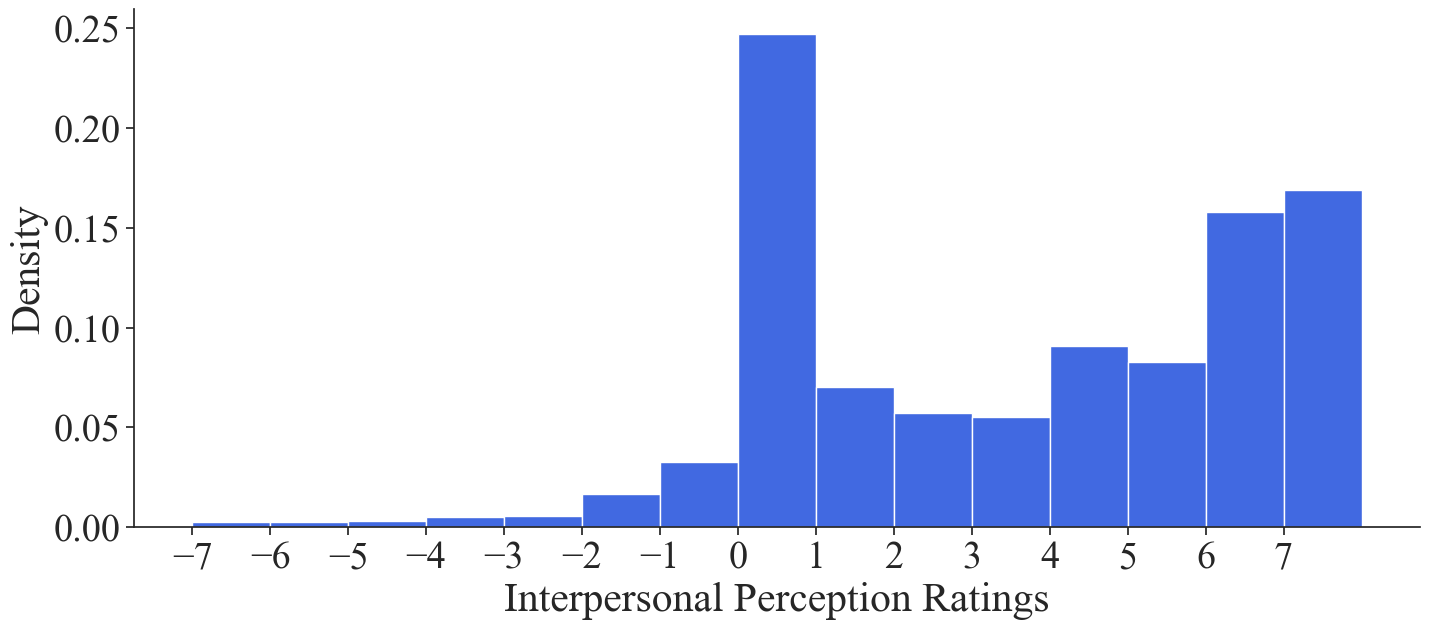

In [27]:
#plot

datapoints = []
value_range_pp = []
value_avg_pp = []
value_std_pp = []

for ind, row in df_interp.iterrows():

    values = df_interp['value'][ind]
    #see range of values
    value_range_pp.append(max(values)-min(values))
    value_avg_pp.append(np.mean(values))
    value_std_pp.append(np.std(values))
    datapoints.extend(values)

#plot just sessions 41 an 38, as a figure with 4 subplots
import tikzplotlib

sns.set(style="ticks", font_scale=2.5)
#import itertools
plt.rcParams["font.family"] = "Times New Roman"


colors0 = ['royalblue']#,'mediumblue','cornflowerblue']
colors1 = ['indianred']#,'firebrick']
colors2 = ['darkgreen']#,'forestgreen','limegreen']
colors3 = ['darkorange']#,'goldenrod','gold']

labs = ['Participant A','Participant B']
fig, ax = plt.subplots(figsize = (15,7))  
#plot distribution of values, with density
#sns.distplot(datapoints, hist=True, color = colors0[0])
#make histogram with bins in np.arange(-7,7,1)
ax.hist(datapoints, bins=[-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8],density=True, color = colors0[0])
#plt.title('Distribution of values')
ax.set_xlabel('Interpersonal Perception Ratings')
ax.set_ylabel('Density')
#set ticks
ax.set_xticks(np.arange(-7,8,1))

#plt.show()

#tq_temp['condition'] == 'datadriven']
#    plt.boxplot(df_postq_tempdd[col], labels = ['DataL'], positions = [ind*2+0.9],  widths = 0.6, patch_artist=True, boxprops=dict(facecolor=colors1[0], color=colors1[0]), medianprops=dict(color='black'), whiskerprops=dict(color='black'), capprops=dict(color='black'))
plt.tight_layout()
sns.despine()
plt.show()
#save with high quality in png
fig.savefig('results1.png', dpi=500)

#tikzplotlib.save("results2.tex")

# Mid Survey Data

In [10]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
from scipy.interpolate import interp1d
#import mse
from sklearn.metrics import mean_squared_error


In [11]:
#import the df_interpolated
df_interp = pd.read_pickle('./dataframes/df_interpolated1dec.pkl')
#import disagreement
df_disagreement = pd.read_pickle('./dataframes/df_disagreement1dec.pkl')

In [12]:
#now, import survey data
df_survey = pd.read_csv('../study_data/survey_data/midq.csv')
#fill in the missing values with string 'NAN'
df_survey = df_survey.fillna('NAN')

In [ ]:
#go through the participants included in the df_interp

#start new, clean participant df
df_midq = pd.DataFrame()
pids = []
sessions = []
ages = []
genders = []
nationalities = []
races = []
proficiencies = []
extraversions = []
agreeablenesses = []
conscientiousnesses = []
neuroticisms = []
opennesses = []
religiousnesses = []
politicals = []
agreeables_general = [] #7-point likert
relationalcs = [] #figure out how to calculate
likingscales = []


#dictionary from likert scale to numerical value
likert_dict = {'Strongly disagree':1,'Somewhat disagree':2,'Neither agree nor disagree':3,'Somewhat agree':4,'Strongly agree':5,'NAN':np.nan}
likert_dict7 = {'Strongly Disagree':1,'Disagree':2,'Somewhat disagree':3,'Neither agree nor disagree':4,'Somewhat agree':5,'Agree':6,'Strongry Agree':7,'NAN':np.nan}
religious_dict = {'Not at all religious':1,'2':2,'3':3,'Somewhat Religious':4,'5':5,'6':6,'Very Religious':7,'NAN':np.nan}
political_dict = {'Very Conservative':1,'10':2,'11':3,'Central':4,'13':5,'14':6,'Very Liberal':7,'NAN':np.nan}


participants = df_interp['participant_number'].unique()
for participant in participants:
    #select the survey data for this participant
    session = np.ceil((participant-1)/2)


    
    if str(participant) in df_survey['Q21'].values:
        print(participant)
        pids.append(participant)
        df_p = df_survey[df_survey['Q21']==str(participant)]
        sessions.append(session)
        ages.append(df_p['Q1'].values[0])
        genders.append(df_p['Q2'].values[0])
        nationalities.append(df_p['Q3'].values[0])
        races.append(df_p['Q4'].values[0])
        proficiencies.append(df_p['Q5'].values[0])
        extra1 = - likert_dict[df_p['Q6_1'].values[0]] + 6
        extra2 = likert_dict[df_p['Q6_6'].values[0]]
        agree1 = likert_dict[df_p['Q6_2'].values[0]]
        agree2 = - likert_dict[df_p['Q6_7'].values[0]] + 6
        conscious1 = - likert_dict[df_p['Q6_3'].values[0]] + 6
        conscious2 = likert_dict[df_p['Q6_8'].values[0]]
        neuro1 = - likert_dict[df_p['Q6_4'].values[0]] + 6
        neuro2 = likert_dict[df_p['Q6_9'].values[0]]
        open1 = - likert_dict[df_p['Q6_5'].values[0]] + 6
        open2 = likert_dict[df_p['Q6_10'].values[0]]
        extraversions.append(extra1 + extra2)
        agreeablenesses.append(agree1 + agree2)
        conscientiousnesses.append(conscious1 + conscious2)
        neuroticisms.append(neuro1 + neuro2)
        opennesses.append(open1 + open2)
        religiousnesses.append(religious_dict[df_p['Q7_1'].values[0]])
        politicals.append(political_dict[df_p['Q22_1'].values[0]])
        agreeables_general.append(df_p['Q14_1'].values[0])
        relation1 = likert_dict7[df_p['Relational Commun_1'].values[0]] #receptivity/social orientation - He/She tried to establish good relations
        relation2 = likert_dict7[df_p['Relational Commun_2'].values[0]] #receptivity - He/She emphasized agreement between us.
        relation3 = likert_dict7[df_p['Relational Commun_3'].values[0]] #receptivity - He/She was willing to listen to me
        relation4 = likert_dict7[df_p['Relational Commun_4'].values[0]] #receptivity - He/She was sincere
        relation5 = likert_dict7[df_p['Relational Commun_5'].values[0]] #receptivity - He/She wanted to appear reasonable
        relation6 = 8 - likert_dict7[df_p['Relational Commun_6'].values[0]] #arousal - He/She was very unemotional
        relation7 = 8 - likert_dict7[df_p['Relational Commun_7'].values[0]] #nonimmediacy - He/She created a sense of distance between us.
        relation8 = 8 - likert_dict7[df_p['Relational Commun_8'].values[0]] #dominance - He/She seemed to have higher status than me
        relation9 = 8 - likert_dict7[df_p['Relational Commun_9'].values[0]] #intimacy - He/She didn't care if I liked him/her
        relation10 = likert_dict7[df_p['Relational Commun_10'].values[0]] #receptivity . He/She wanted me to trust him/her
        relation11 = likert_dict7[df_p['Relational Commun_11'].values[0]] #intimacy .  He/she expressed attraction towards me
        relation12 = likert_dict7[df_p['Relational Commun_12'].values[0]] #intimacy - He/she made the conversation seem intimate
        relation13 = likert_dict7[df_p['Relational Commun_13'].values[0]] #dominance ? - He/she considered us equals.
        relation14 = likert_dict7[df_p['Relational Commun_14'].values[0]]#composure/emotional non arousal - He/she felt very relaxed talking with me
        relation15 = 8 - likert_dict7[df_p['Relational Commun_15'].values[0]] #arousal/Intimacy/involvement - He/she acted bored by the conversation
        relation16 = 8 - likert_dict7[df_p['Relational Commun_16'].values[0]] #nonimmediacy/intimacy/depth - He/she made the conversation seem superficial.
        relationalcs.append(np.nan) #TODO TODO TODO TODO TODO TODO
        liking1 = likert_dict7[df_p['liking scale_1'].values[0]] #liking
        liking2 = likert_dict7[df_p['liking scale_2'].values[0]] #liking
        liking3 = likert_dict7[df_p['liking scale_3'].values[0]] #liking
        liking4 = likert_dict7[df_p['liking scale_4'].values[0]] #liking
        liking5 = likert_dict7[df_p['liking scale_5'].values[0]] #liking
        liking6 = likert_dict7[df_p['liking scale_6'].values[0]] #liking
        liking7 = likert_dict7[df_p['liking scale_7'].values[0]] #liking
        likingscales.append((liking1 + liking2 + liking3 + liking4 + liking5 + liking6 + liking7)/7)


df_midq['participant'] = pids 
df_midq['session'] = sessions
df_midq['age'] = ages
df_midq['gender'] = genders
df_midq['nationality'] = nationalities
df_midq['race'] = races
df_midq['proficiency'] = proficiencies
df_midq['extraversion'] = extraversions
df_midq['agreeableness'] = agreeablenesses
df_midq['conscientiousness'] = conscientiousnesses
df_midq['neuroticism'] = neuroticisms
df_midq['openness'] = opennesses
df_midq['religiousness'] = religiousnesses
df_midq['political'] = politicals
df_midq['agreeable_general'] = agreeables_general
df_midq['relationalc'] = relationalcs
df_midq['likingscale'] = likingscales
    
#save
df_midq.to_pickle('./dataframes/midq_processed.pkl')
#save to csv
df_midq.to_csv('./dataframes/midq_processed.csv', index=False)

df_midq


# Disagreement from CORAE

In [28]:
#imports
import pandas as pd
from sklearn.metrics import cohen_kappa_score

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
from scipy.interpolate import interp1d
#import mse
from sklearn.metrics import mean_squared_error
import scipy.stats as stats
import itertools
from scipy.stats import pearsonr
from scipy.integrate import trapz
import tikzplotlib

#for plots
import matplotlib as mpl

sns.set(style="whitegrid", font_scale=1.2)#, font='Arial')
#sns.set_palette("husl")
#plt.rcParams.update({'font.size': '50'})
#plt.rcParams['font.size'] = '50'
#mpl.rcParams['font.family'] = 'Arial'

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from termcolor import colored


In [29]:
#open df_interp
df_interp = pd.read_pickle('./dataframes/df_interpolated1dec.pkl')
#open midq
df_midq = pd.read_pickle('./dataframes/midq_processed.pkl')

In [ ]:


#now, we are able to determine disagreement between participants, by comparing the values across a session for the participants in it
#we can do this by calculating the mean squared error between the values of the participants (?) or by calculating the correlation between the values of the participants (?)
#also, we can just calculate the absolute difference and normalize it through time


#first, select session
sessions = df_interp['session'].unique()
#create a dataframe to store this
df_disagreement = pd.DataFrame(columns=['session','mse','corr','abs_diff', 'cohen_kappa','valuesum','interpersonal_list','interpersonal_diff', 'agreeable_general_sum','likingscale_sum',
                                        'extraversion_diff','agreeableness_diff','conscientiousness_diff','neuroticism_diff','openness_diff',
                                        'religiousness_diff','political_diff','agreeable_general_diff','relationalc_diff','likingscale_diff', 'valuesum_diff',
                                        
                                        'extraversion',
                                        'agreeableness','conscientiousness','neuroticism','openness','religiousness','political','agreeable_general','relationalc','likingscale'], index=range(len(sessions)))


for session in sessions:
    df_session = df_interp[df_interp['session']==session]
    print(df_session['participant_number'].values)
    #get values for both participants
    value_list = df_session['value'].values
    x = df_session['frame_seconds'].values
    #derivative
    derivative_list = df_session['derivative'].values
    
    #calculate mean squared error
    mse = mean_squared_error(value_list[0],value_list[1])

    #calculate correlation
    corr = np.corrcoef(value_list[0],value_list[1])[0,1]
    #calculate absolute difference
    abs_diff = np.sum(np.abs(value_list[0]-value_list[1]))/len(value_list[0])
    #calculate cohen kappa score
    cohen_kappa = cohen_kappa_score(value_list[0],value_list[1])
    #calculate interpersonal difference
    #do this by calculating the cumulative sum of values for each participant, and then calculating the difference between the two (save the values in a list)
    valuesum = np.abs(np.sum(value_list[0]) - np.sum(value_list[1]))/len(value_list[0])
    valuesum_list = [np.sum(value_list[0])/len(value_list[0]),np.sum(value_list[1])/len(value_list[0])]
    #area under curve for each participant
    y0 = np.array(value_list[0])
    x0 = np.array(x[0])
    area0 = (np.trapz(y0[y0>0],x0[y0>0]) - np.trapz(y0[y0<0],x0[y0<0]))/len(value_list[0])
    y1 = np.array(value_list[1])
    x1 = np.array(x[1])
    area1 = (np.trapz(y1[y1>0],x1[y1>0]) - np.trapz(y1[y1<0],x1[y1<0]))/len(value_list[0])
    interpersonal_list = [area0,area1]
    interpersonal_diff = np.abs(area0-area1)
    #then, get the midq values for each session
    midqsession = df_midq[df_midq['session']==session]
    #get the values for the midq
    midqvalues = midqsession['extraversion'].values
    #add to df_disagreement as list
    extraversion = midqvalues.tolist()
    extraversion_diff = np.abs(extraversion[0]-extraversion[1])
    #repeat for all other midq values
    midqvalues = midqsession['agreeableness'].values
    agreeableness = midqvalues.tolist()
    agreeableness_diff = np.abs(agreeableness[0]-agreeableness[1])
    midqvalues = midqsession['conscientiousness'].values
    conscientiousness = midqvalues.tolist()
    conscientiousness_diff = np.abs(conscientiousness[0]-conscientiousness[1])
    midqvalues = midqsession['neuroticism'].values
    neuroticism = midqvalues.tolist()
    neuroticism_diff = np.abs(neuroticism[0]-neuroticism[1])
    midqvalues = midqsession['openness'].values
    openness = midqvalues.tolist()
    openness_diff = np.abs(openness[0]-openness[1])
    midqvalues = midqsession['religiousness'].values
    religiousness = midqvalues.tolist()
    religiousness_diff = np.abs(religiousness[0]-religiousness[1])
    midqvalues = midqsession['political'].values
    political = midqvalues.tolist()
    political_diff = np.abs(political[0]-political[1])
    midqvalues = midqsession['agreeable_general'].values
    agreeable_general = midqvalues.tolist()
    agreeable_general_diff = np.abs(float(agreeable_general[0])-float(agreeable_general[1]))
    agreeable_general_sum = float(agreeable_general[0])+float(agreeable_general[1])
    midqvalues = midqsession['relationalc'].values
    relationalc = midqvalues.tolist()
    relationalc_diff = np.abs(float(relationalc[0])-float(relationalc[1]))
    midqvalues = midqsession['likingscale'].values
    likingscale = midqvalues.tolist()
    likingscale_diff = np.abs(float(likingscale[0])-float(likingscale[1]))
    likingscale_sum = np.sum(likingscale)
    
    #add to df_disagreement
    df_disagreement.loc[df_session.index[0]/2] = [session,mse,corr,abs_diff,cohen_kappa,valuesum,interpersonal_list,interpersonal_diff, agreeable_general_sum,likingscale_sum,
                                                  extraversion_diff,agreeableness_diff,conscientiousness_diff,neuroticism_diff,openness_diff,
                                                  religiousness_diff,political_diff,agreeable_general_diff,relationalc_diff,likingscale_diff, valuesum_list,
                                                  extraversion,
                                                  agreeableness,conscientiousness,neuroticism,openness,religiousness,political,agreeable_general,relationalc,likingscale]


#save df_disagreement
df_disagreement.to_pickle('./dataframes/df_disagreement1dec.pkl')
#to csv
df_disagreement.to_csv('./dataframes/df_disagreement1dec.csv')

df_disagreement
    




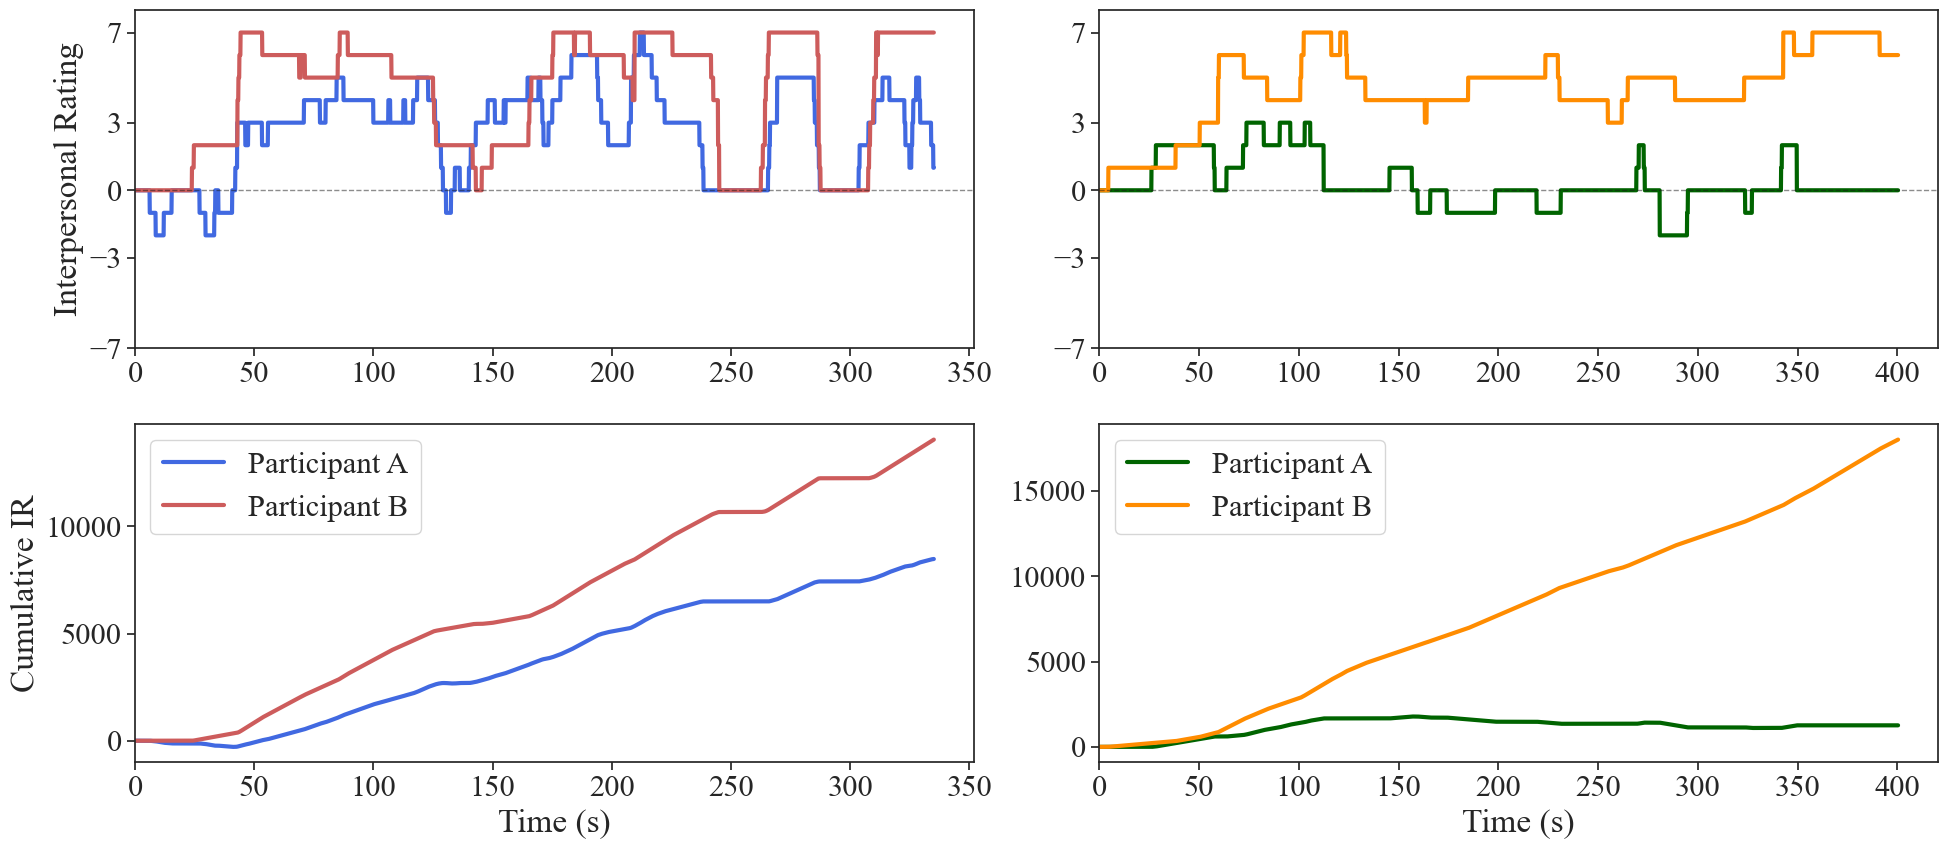

In [34]:
#plot just sessions 41 an 38, as a figure with 4 subplots
import tikzplotlib

sns.set(style="ticks", font_scale=2)
#import itertools
plt.rcParams["font.family"] = "Times New Roman"


colors0 = ['royalblue']#,'mediumblue','cornflowerblue']
colors1 = ['indianred']#,'firebrick']
colors2 = ['darkgreen']#,'forestgreen','limegreen']
colors3 = ['darkorange']#,'goldenrod','gold']

labs = ['Participant A','Participant B']
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize = (20,9))  

sessions = [41,38]
for session in sessions:
    df_session = df_interp[df_interp['session']==session]
    #for each participant
    participants = df_session['participant_number'].unique()
    if session == 41:
        x = np.array(df_session['frame_seconds'].values[0])
        y0 = np.array(df_session['value'].values[0])
        ax1.plot(x,y0,label = labs[0], color = colors0[0],linewidth=3)
        y1 = np.array(df_session['value'].values[1])
        ax1.plot(x,y1,label = labs[1], color = colors1[0],linewidth=3)
        #now, plot the cumulative sum
        y_cumsum0 = np.array(df_session['cumsum'].values[0])
        ax3.plot(x,y_cumsum0,label = labs[0], color = colors0[0],linewidth=3)
        y_cumsum1 = np.array(df_session['cumsum'].values[1])
        ax3.plot(x,y_cumsum1,label = labs[1], color = colors1[0],linewidth=3)
    else:
        x = np.array(df_session['frame_seconds'].values[0])
        y0 = np.array(df_session['value'].values[0])
        ax2.plot(x,y0,label = labs[0], color = colors2[0],linewidth=3)
        y1 = np.array(df_session['value'].values[1])
        ax2.plot(x,y1,label = labs[1], color = colors3[0],linewidth=3)
        #now, plot the cumulative sum
        y_cumsum0 = np.array(df_session['cumsum'].values[0])
        ax4.plot(x,y_cumsum0,label = labs[0], color = colors2[0],linewidth=3)
        y_cumsum1 = np.array(df_session['cumsum'].values[1])
        ax4.plot(x,y_cumsum1,label = labs[1], color = colors3[0],linewidth=3)

#ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Interpersonal Rating')
#set scale from -7 to 7
ax1.set_ylim([-7,8])
#set yticks
ax1.set_yticks([-7,-3,0,3,7])
#add horizontal dashed line at 0
ax1.axhline(y=0, color='k', linestyle='--',linewidth=1, alpha = 0.5)
#set minimum x value to 0, but no upper bound
ax1.set_xlim([0,None])
#ax2.set_xlabel('Time (s)')
#ax2.set_ylabel('Interpersonal Rating')
#set scale from -7 to 7
ax2.set_ylim([-7,8])
#set yticks
ax2.set_yticks([-7,-3,0,3,7])
#add horizontal dashed line at 0
ax2.axhline(y=0, color='k', linestyle='--',linewidth=1, alpha = 0.5)
#set minimum x value to 0, but no upper bound
ax2.set_xlim([0,None])
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Cumulative IR')
#set minimum x value to 0, but no upper bound
ax3.set_xlim([0,None])
ax4.set_xlabel('Time (s)')
#ax4.set_ylabel('Cumulative IR')
#set minimum x value to 0, but no upper bound
ax4.set_xlim([0,None])
#put legend in lower left corner
#ax1.legend(loc = 'lower left')
ax3.legend()
ax4.legend()

#tq_temp['condition'] == 'datadriven']
#    plt.boxplot(df_postq_tempdd[col], labels = ['DataL'], positions = [ind*2+0.9],  widths = 0.6, patch_artist=True, boxprops=dict(facecolor=colors1[0], color=colors1[0]), medianprops=dict(color='black'), whiskerprops=dict(color='black'), capprops=dict(color='black'))
plt.tight_layout()
#sns.despine()
plt.show()
#save with high quality in png
fig.savefig('../figures/results2.png', dpi=300)

#tikzplotlib.save("results2.tex")


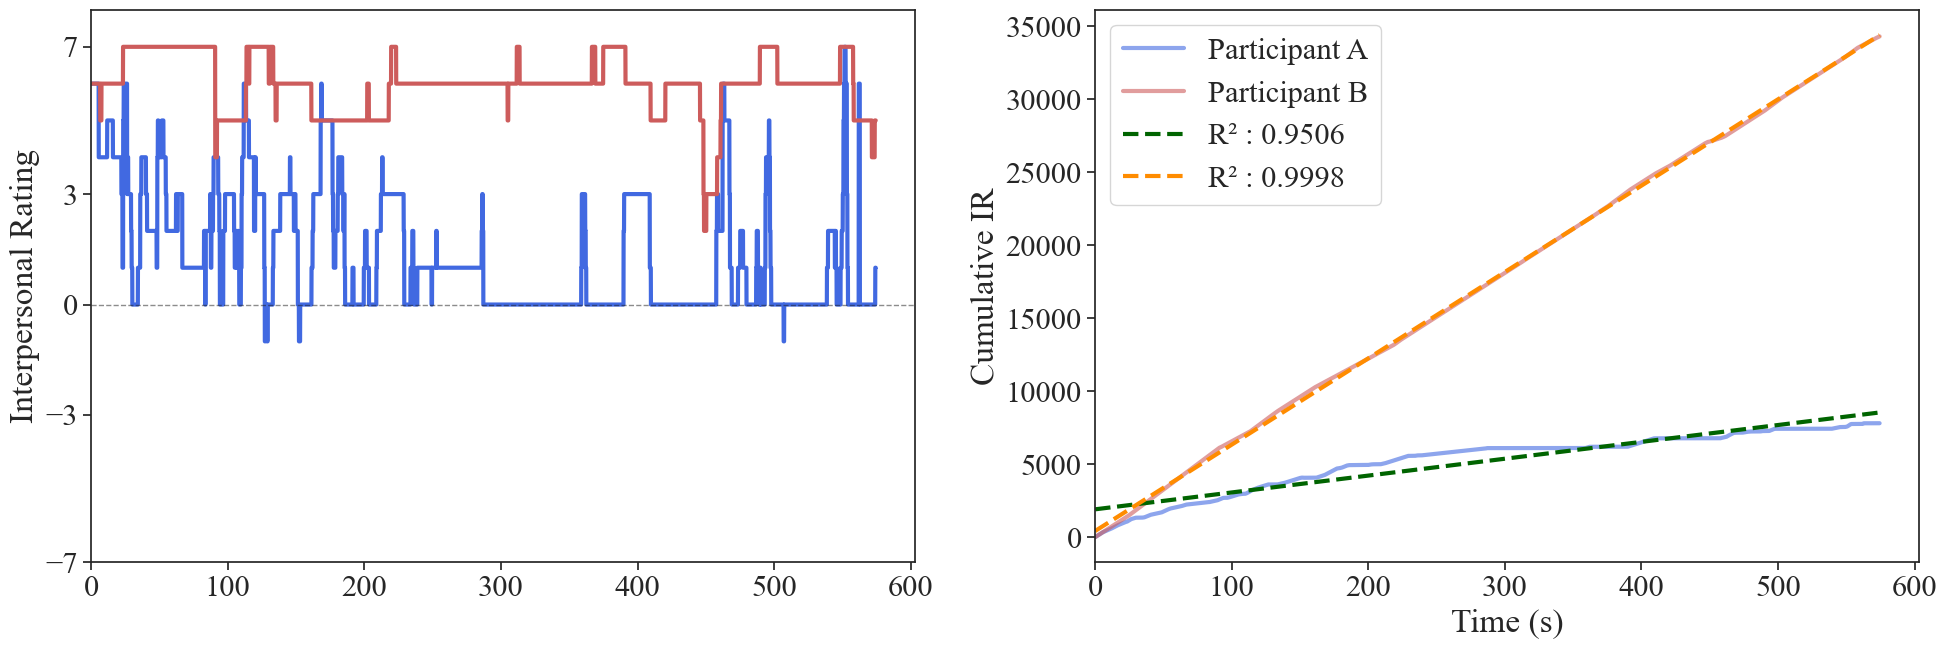

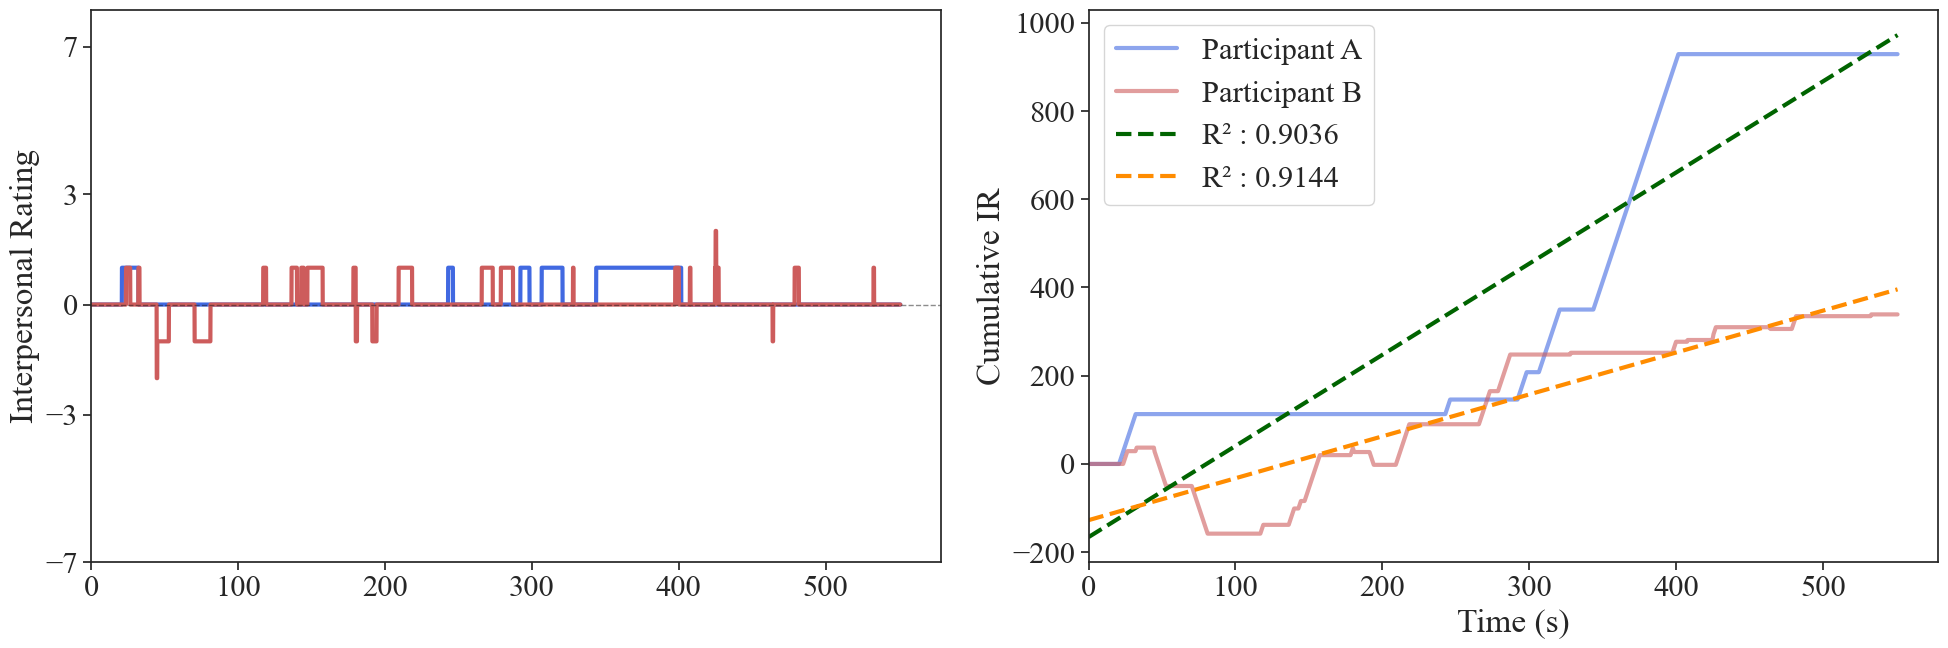

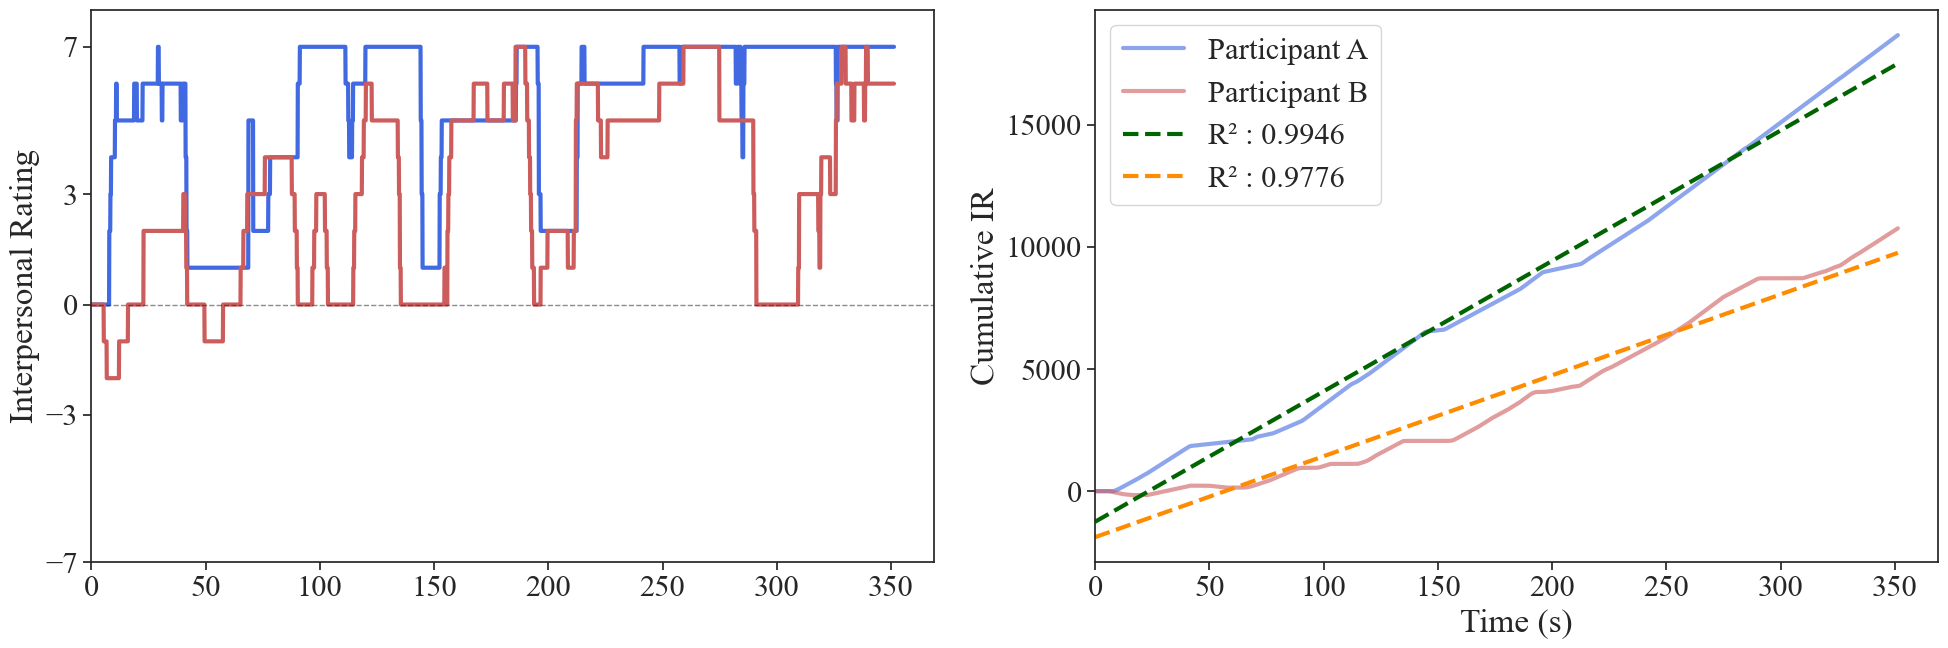

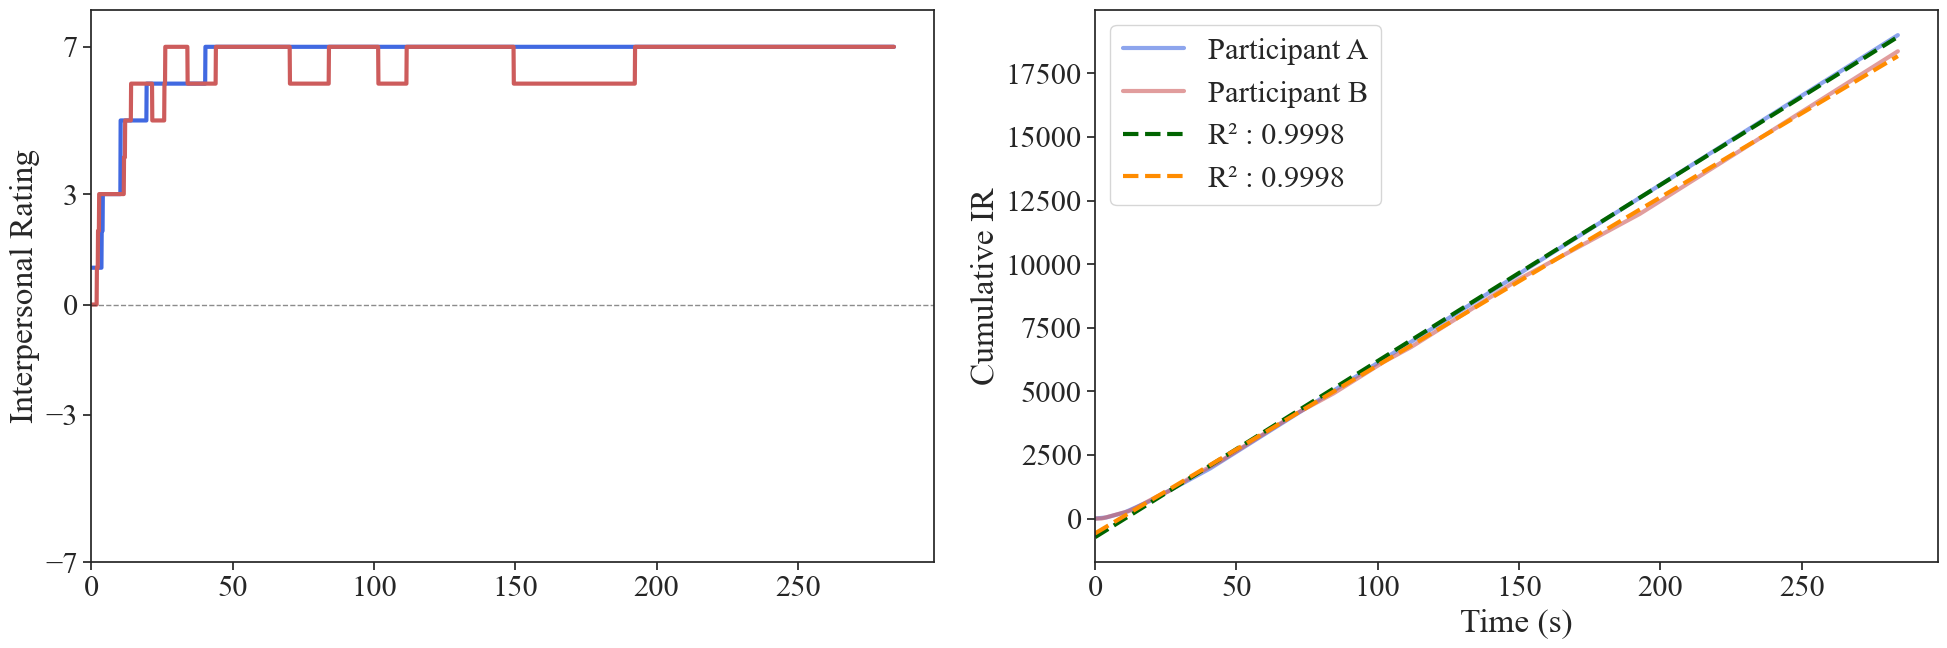

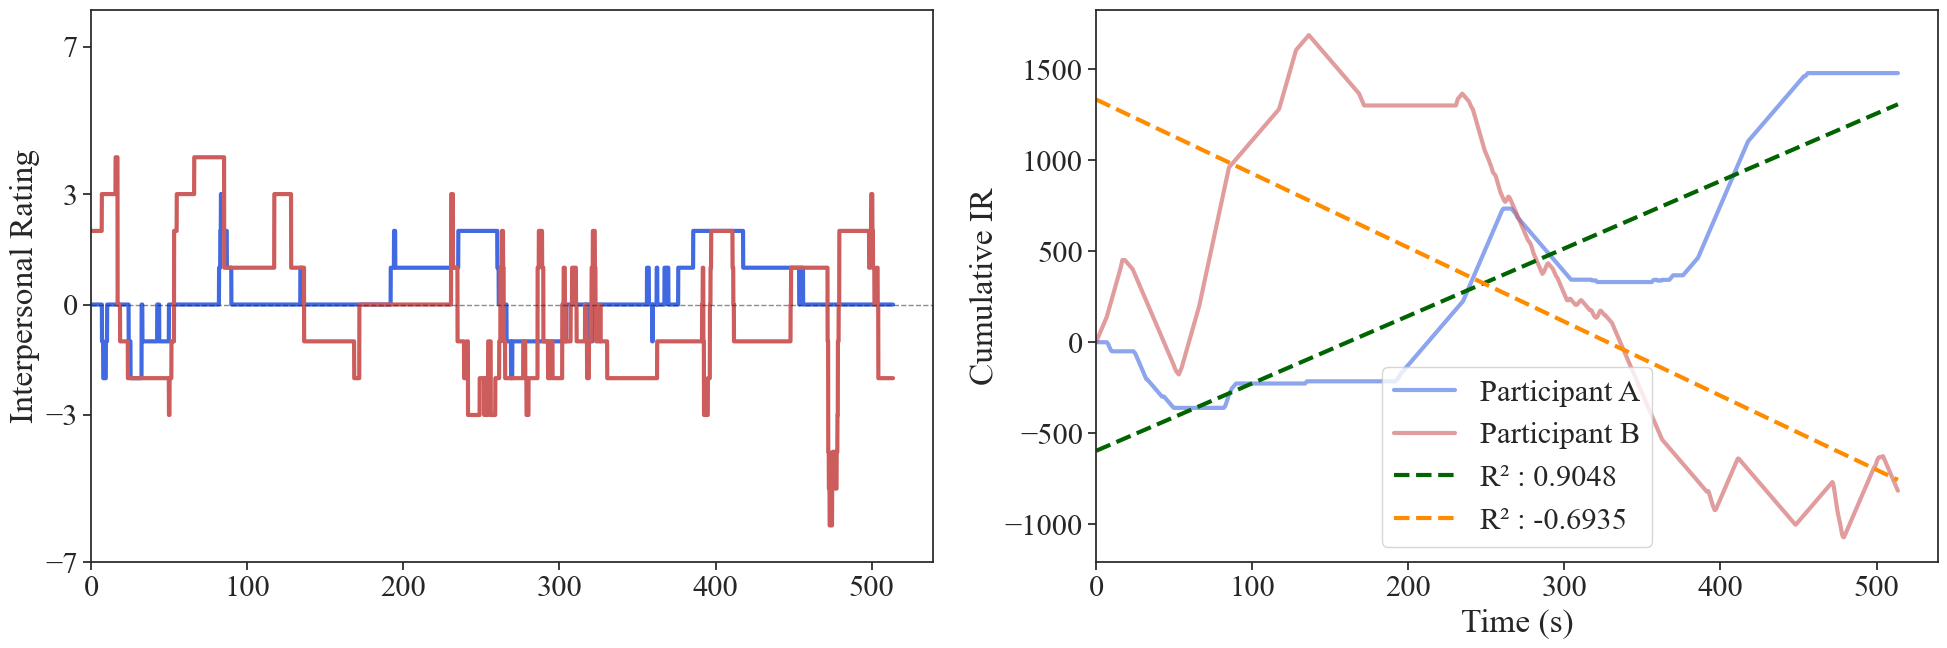

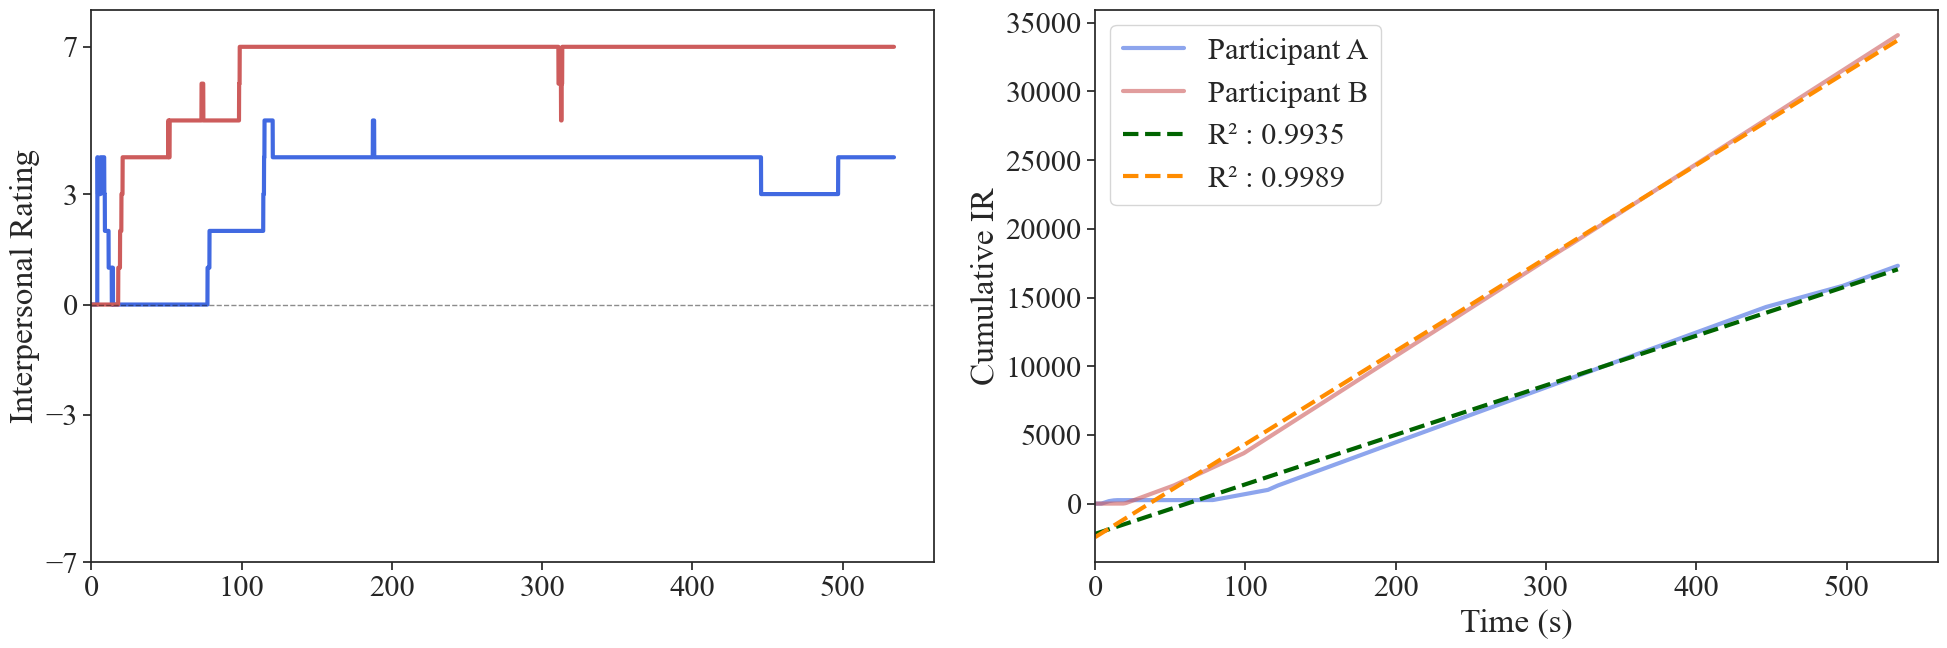

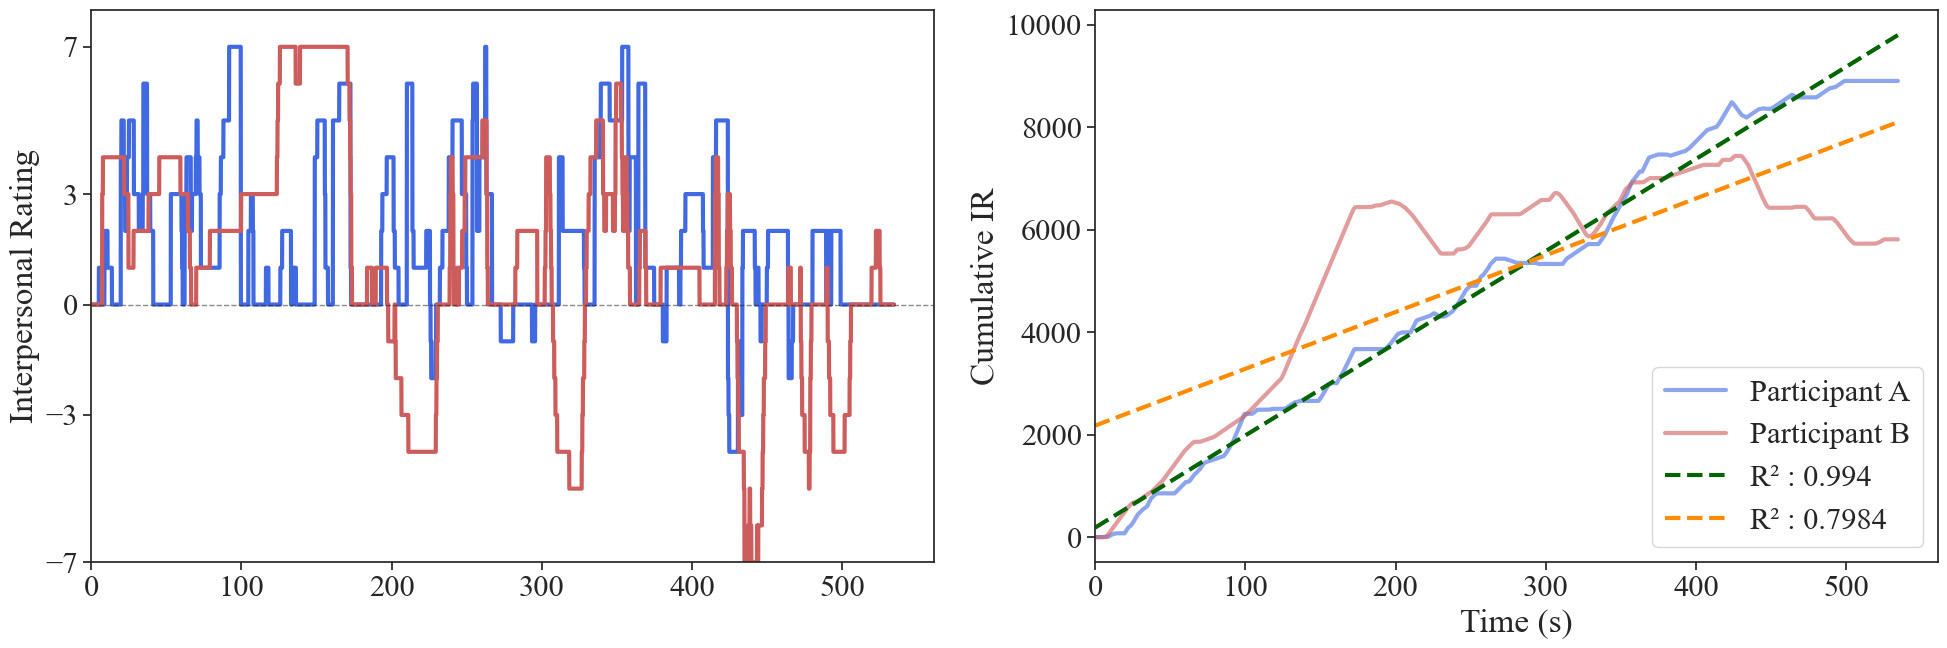

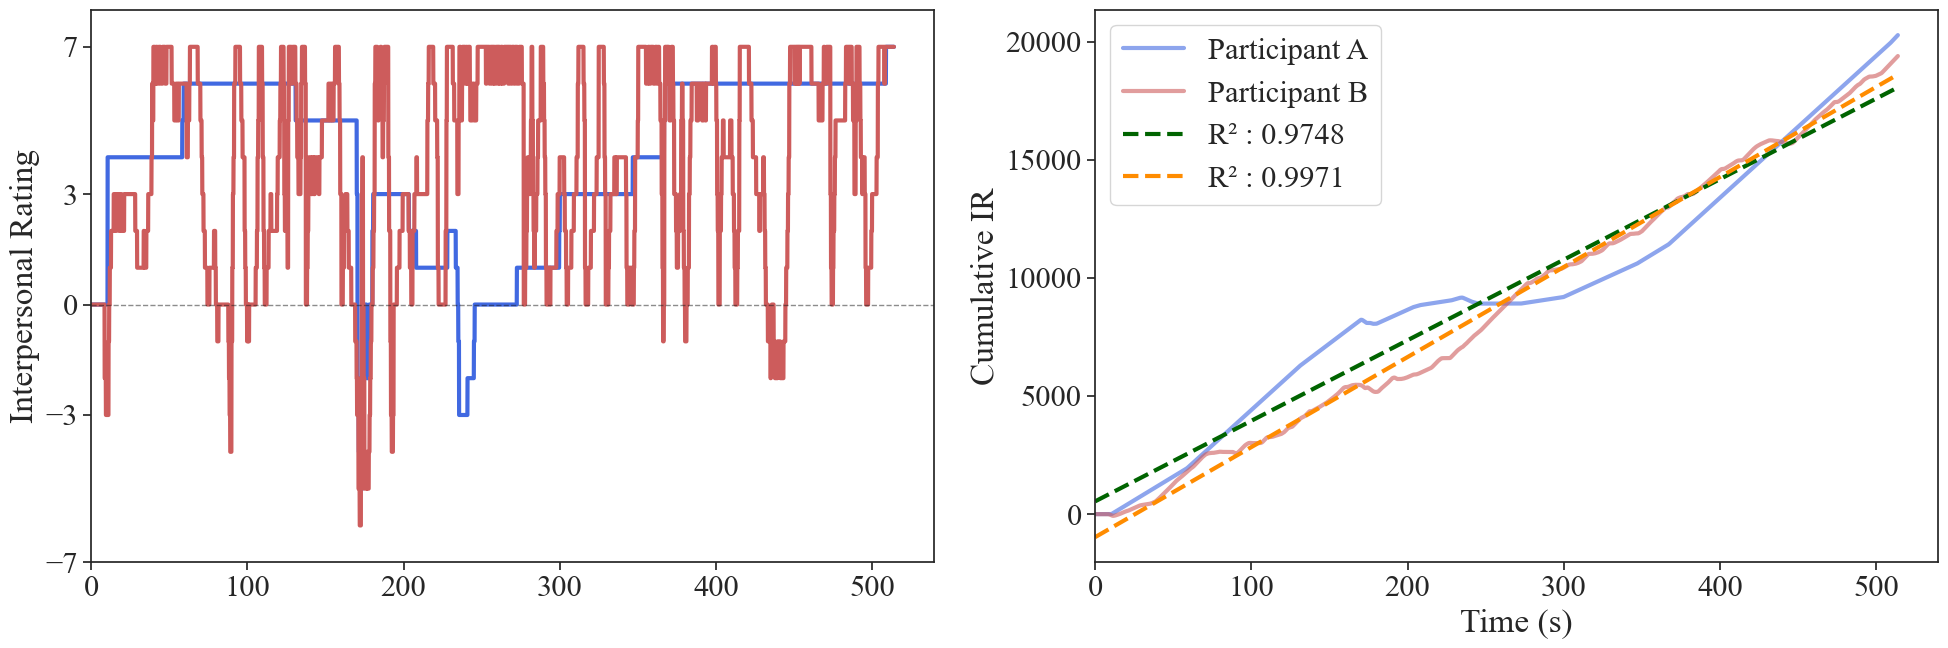

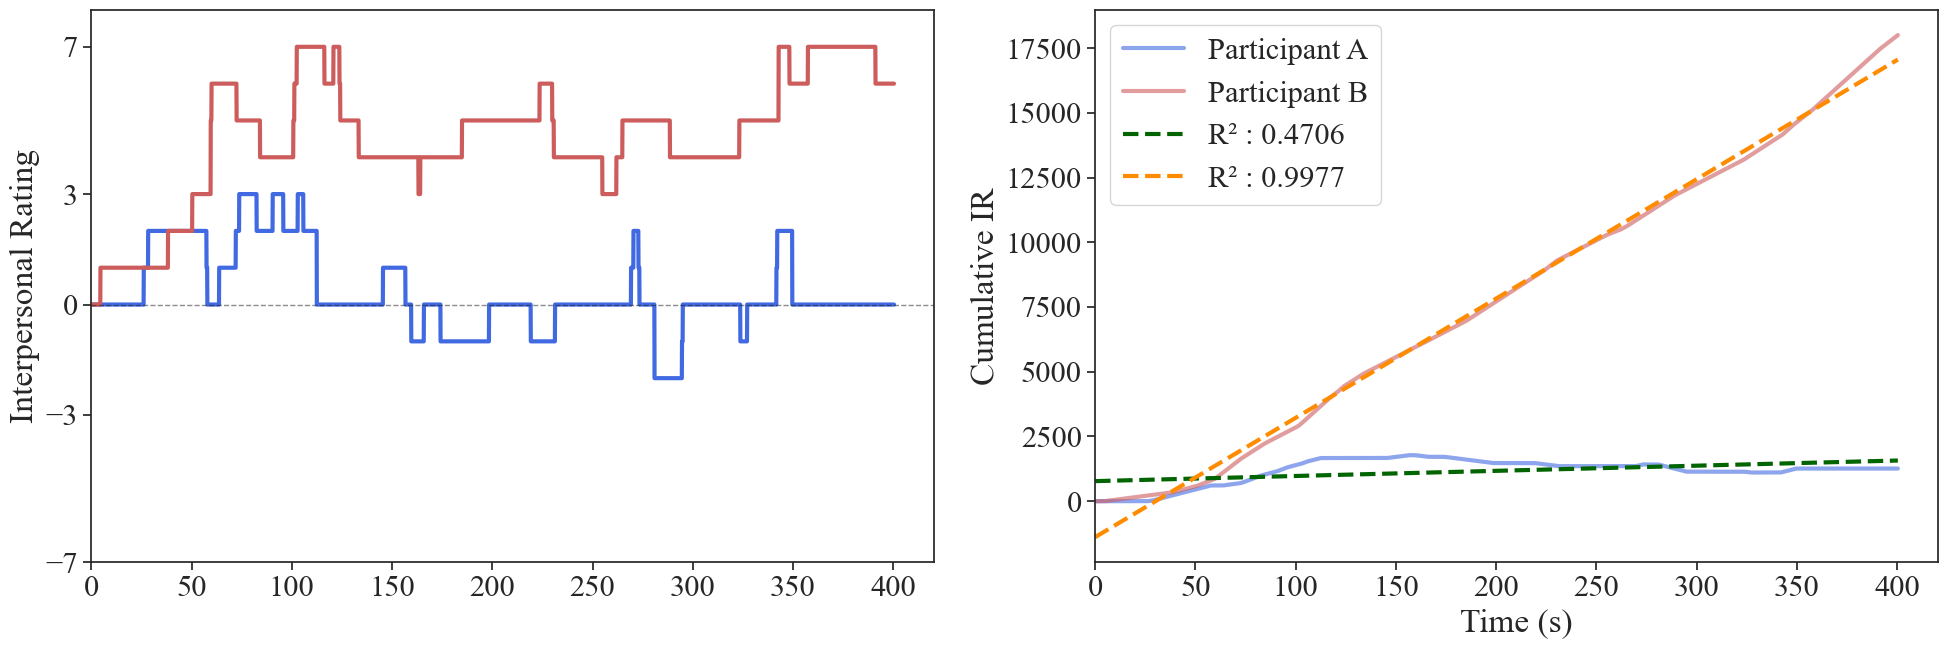

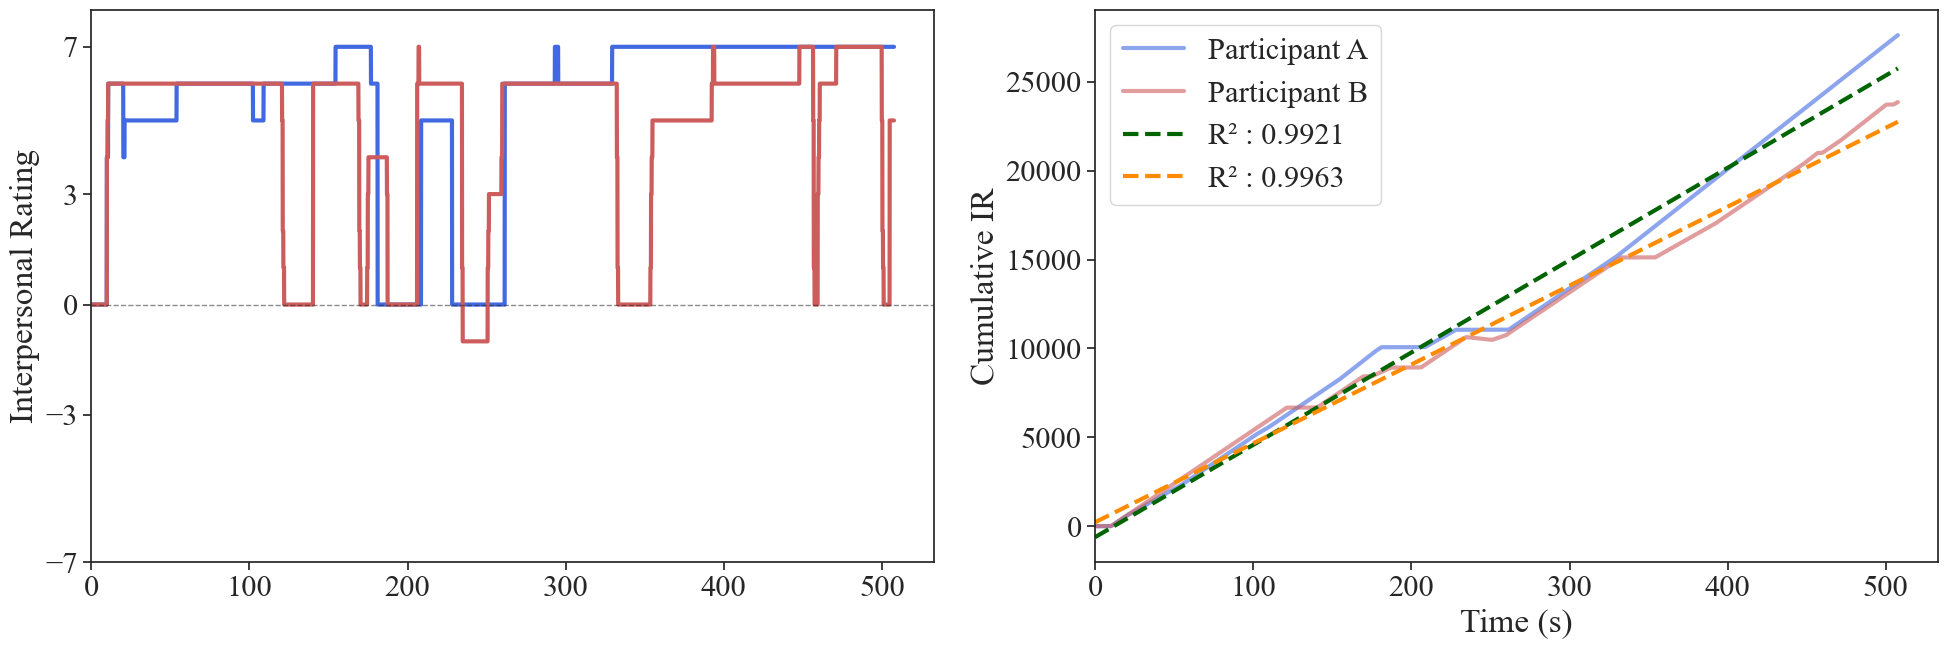

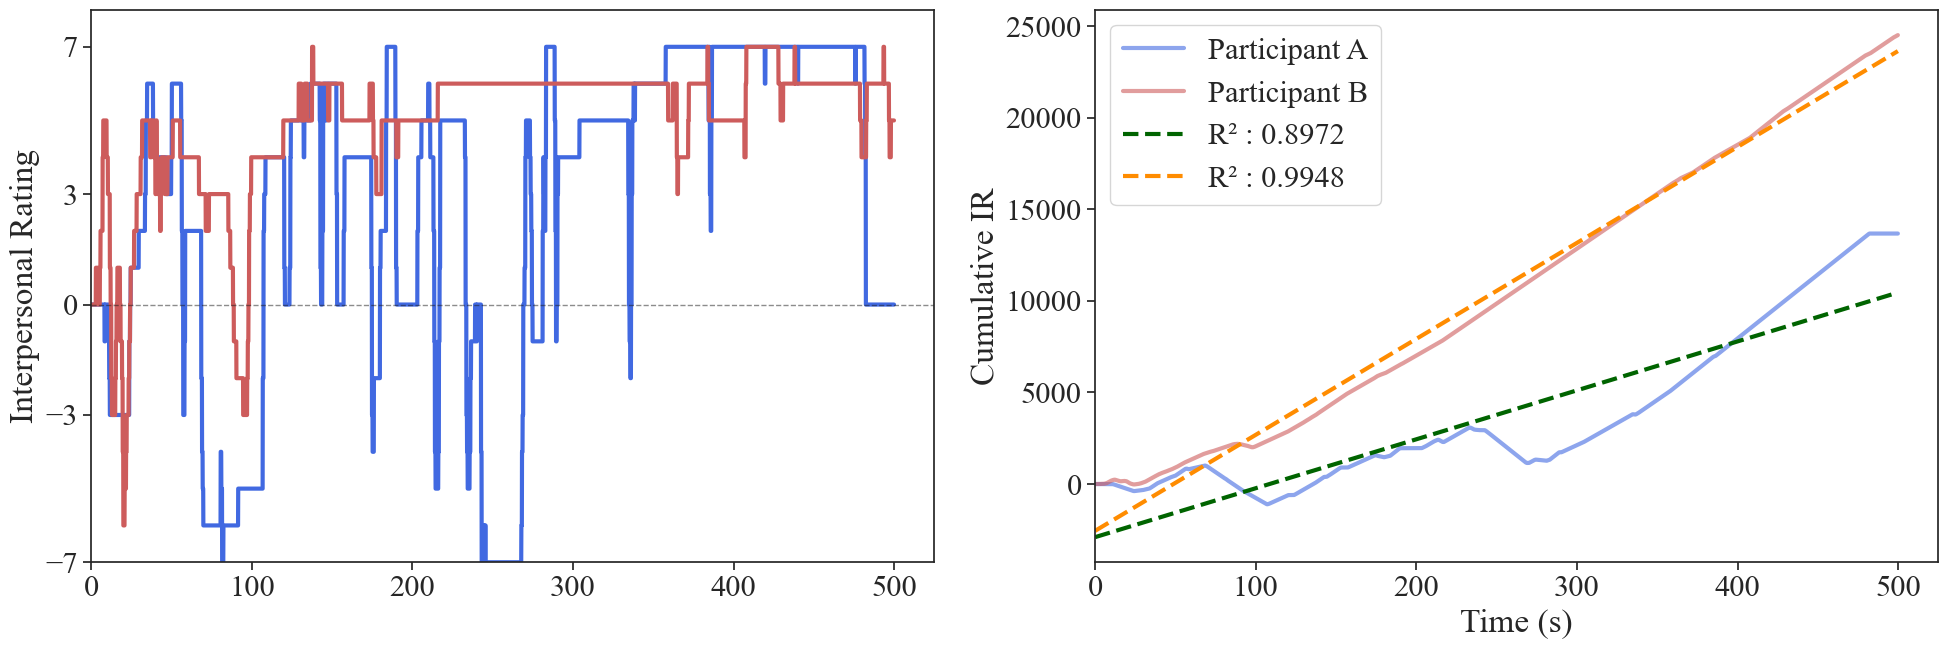

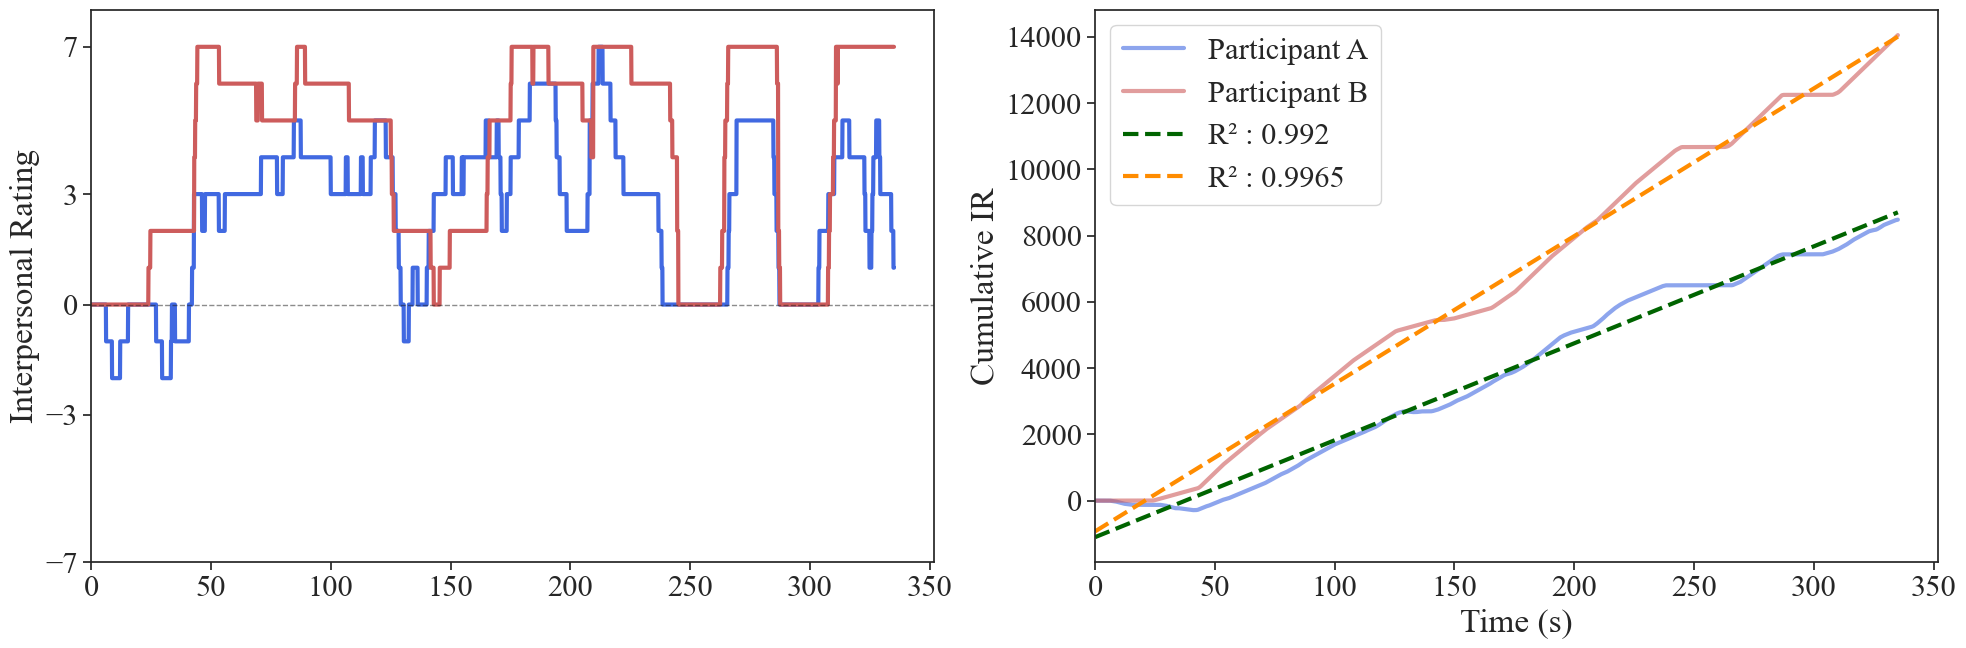

In [40]:
#plot all sessions
import tikzplotlib

sns.set(style="ticks", font_scale=2)
#import itertools
plt.rcParams["font.family"] = "Times New Roman"


colors0 = ['royalblue']#,'mediumblue','cornflowerblue']
colors1 = ['indianred']#,'firebrick']
colors2 = ['darkgreen']#,'forestgreen','limegreen']
colors3 = ['darkorange']#,'goldenrod','gold']

labs = ['Participant A','Participant B']

sessions = df_interp['session'].unique()
for session in sessions:
    df_session = df_interp[df_interp['session']==session]
    #for each participant
    participants = df_session['participant_number'].unique()
    fig, (ax1,ax2) = plt.subplots(1,2,figsize = (20,7))  

    x = np.array(df_session['frame_seconds'].values[0])
    y0 = np.array(df_session['value'].values[0])
    ax1.plot(x,y0,label = labs[0], color = colors0[0],linewidth=3)
    y1 = np.array(df_session['value'].values[1])
    ax1.plot(x,y1,label = labs[1], color = colors1[0],linewidth=3)
    #now, plot the cumulative sum
    y_cumsum0 = np.array(df_session['cumsum'].values[0])
    ax2.plot(x,y_cumsum0,label = labs[0], color = colors0[0],alpha = 0.6, linewidth=3)
    y_cumsum1 = np.array(df_session['cumsum'].values[1])
    ax2.plot(x,y_cumsum1,label = labs[1], color = colors1[0],alpha = 0.6, linewidth=3)

    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y_cumsum0)
    line = slope*x+intercept
    ax2.plot(x,line,'--',color = colors2[0],linewidth=3,label = 'R\u00b2 : ' + str(round(r_value, 4)))
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y_cumsum1)
    line = slope*x+intercept
    ax2.plot(x,line,'--',color = colors3[0],linewidth=3, label = 'R\u00b2 : ' + str(round(r_value, 4)))

    #ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Interpersonal Rating')
    #set scale from -7 to 7
    ax1.set_ylim([-7,8])
    #set yticks
    ax1.set_yticks([-7,-3,0,3,7])
    #add horizontal dashed line at 0
    ax1.axhline(y=0, color='k', linestyle='--',linewidth=1, alpha = 0.5)
    #set minimum x value to 0, but no upper bound
    ax1.set_xlim([0,None])

    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Cumulative IR')
    #set minimum x value to 0, but no upper bound
    ax2.set_xlim([0,None])
    ax2.legend()

    #tq_temp['condition'] == 'datadriven']
    #    plt.boxplot(df_postq_tempdd[col], labels = ['DataL'], positions = [ind*2+0.9],  widths = 0.6, patch_artist=True, boxprops=dict(facecolor=colors1[0], color=colors1[0]), medianprops=dict(color='black'), whiskerprops=dict(color='black'), capprops=dict(color='black'))
    plt.tight_layout()
    #sns.despine()
    plt.show()  
    #save with high quality in png
    fig.savefig('../figures/supp' + str(session) + '.png', dpi=300)

#tikzplotlib.save("results2.tex")

5745 5745
5745 5745


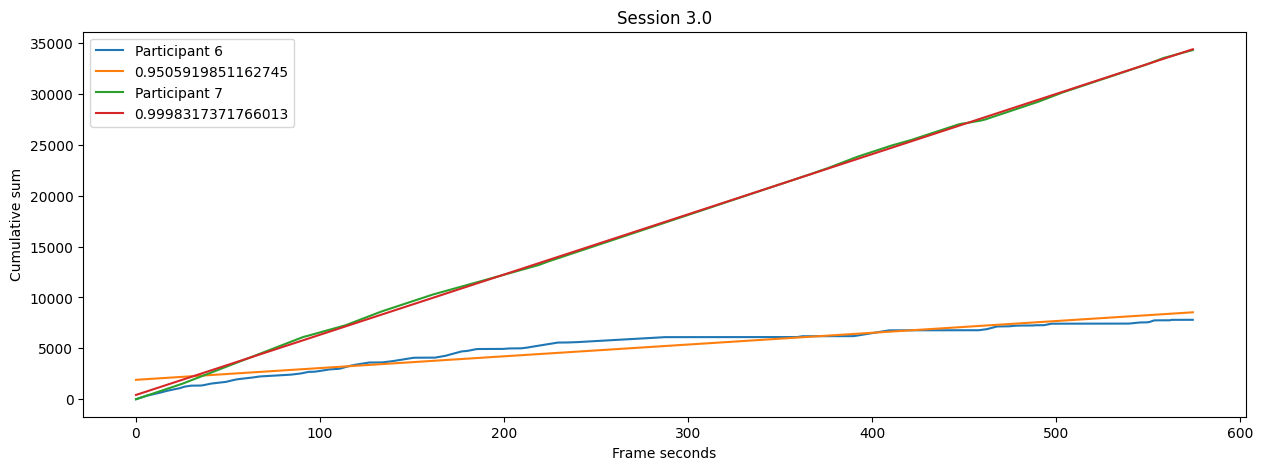

5509 5509
5509 5509


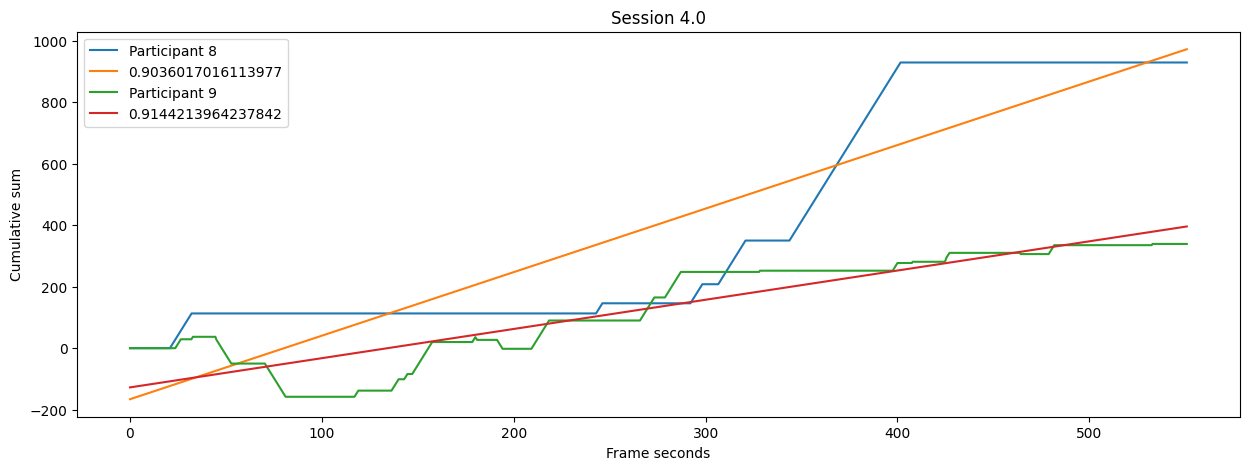

3514 3514
3514 3514


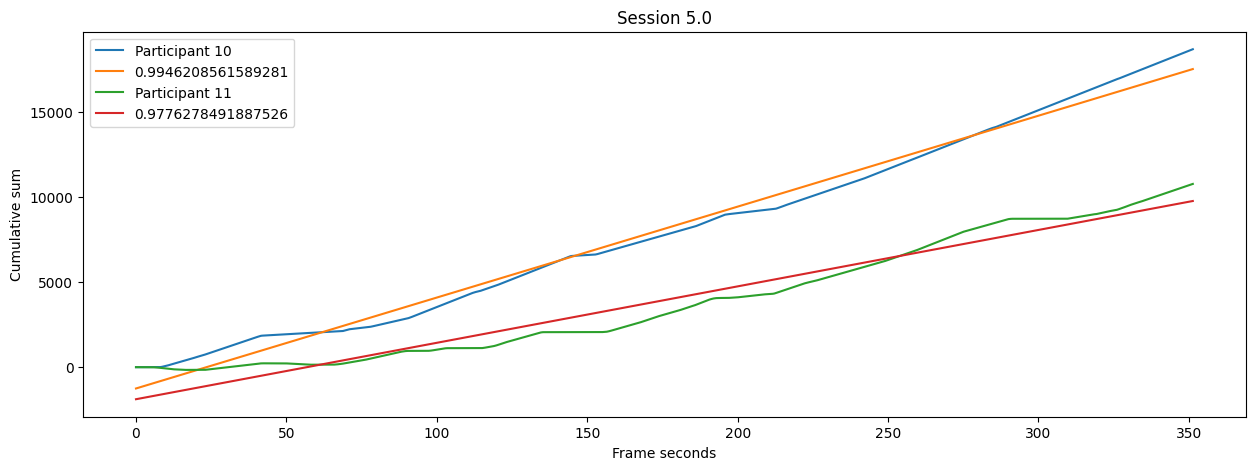

2841 2841
2841 2841


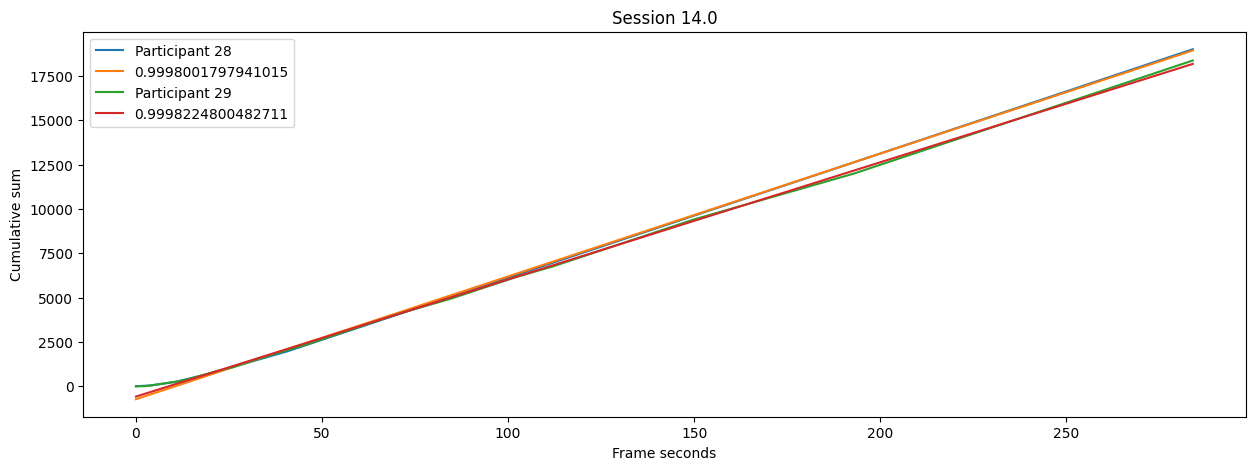

5138 5138
5138 5138


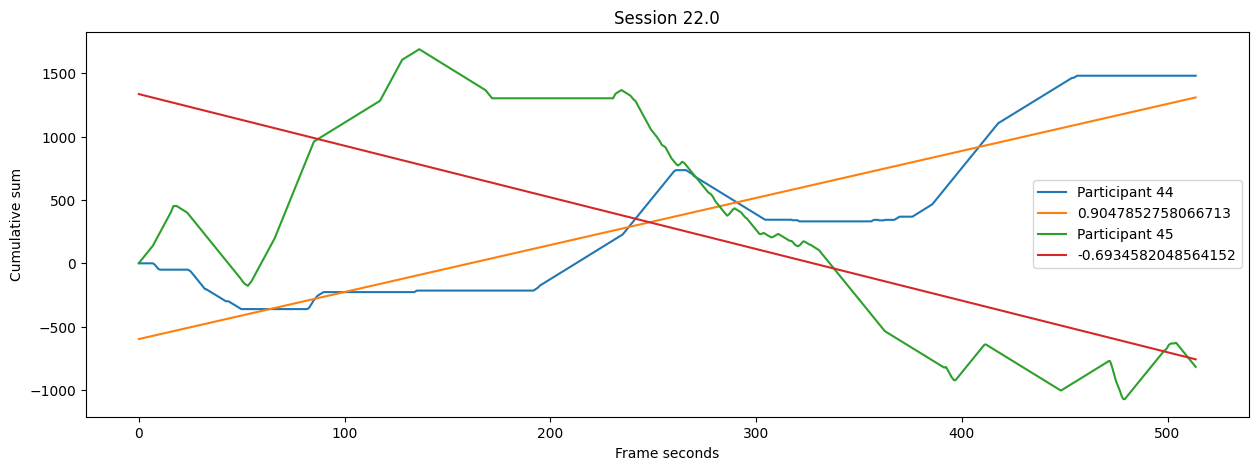

5342 5342
5342 5342


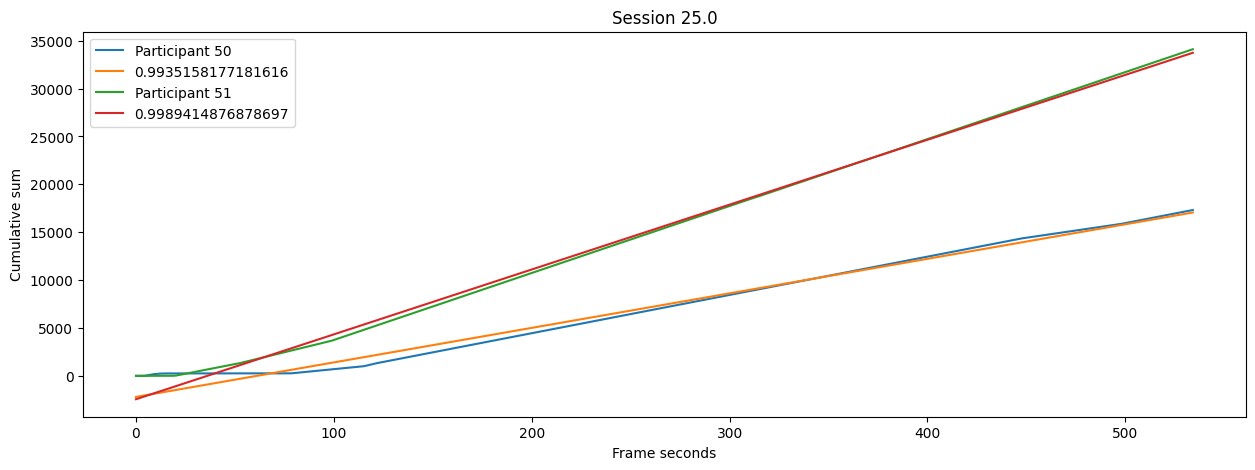

5344 5344
5344 5344


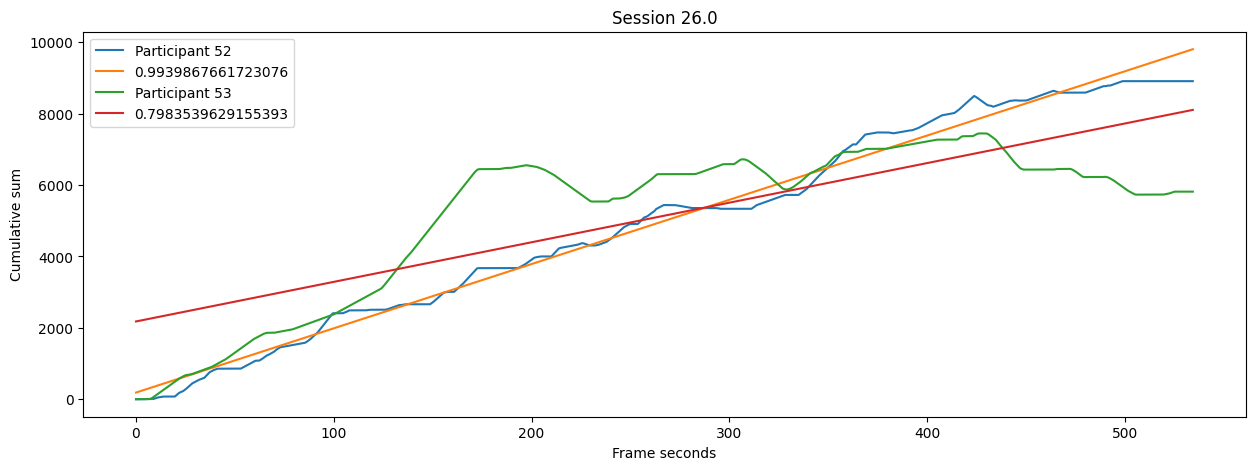

5140 5140
5140 5140


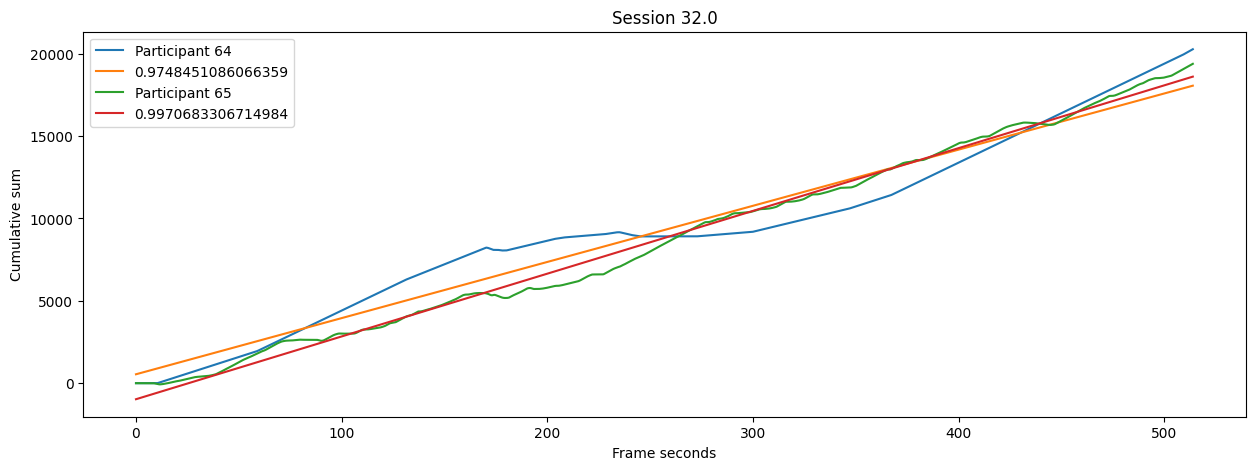

4004 4004
4004 4004


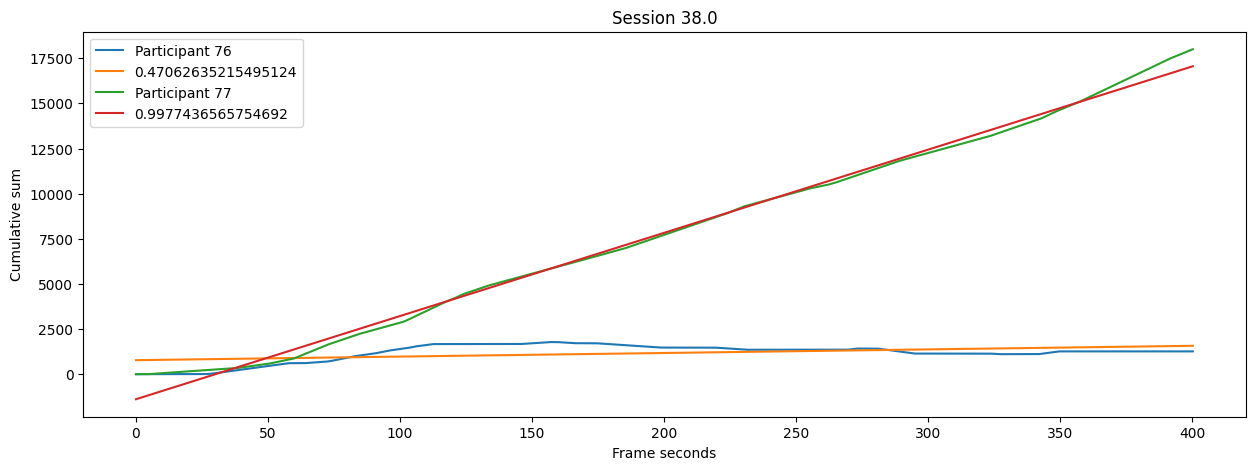

5077 5077
5077 5077


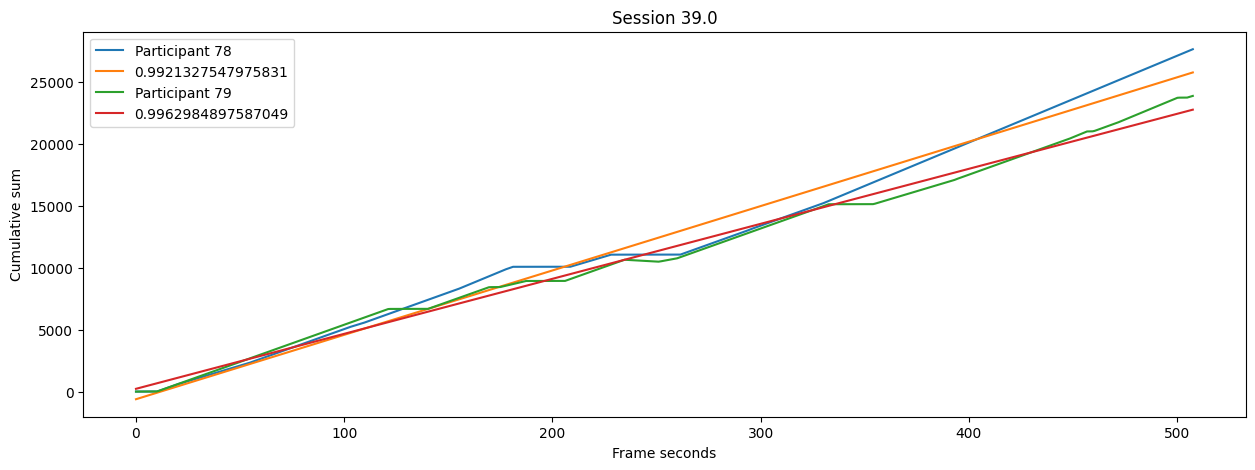

4999 4999
4999 4999


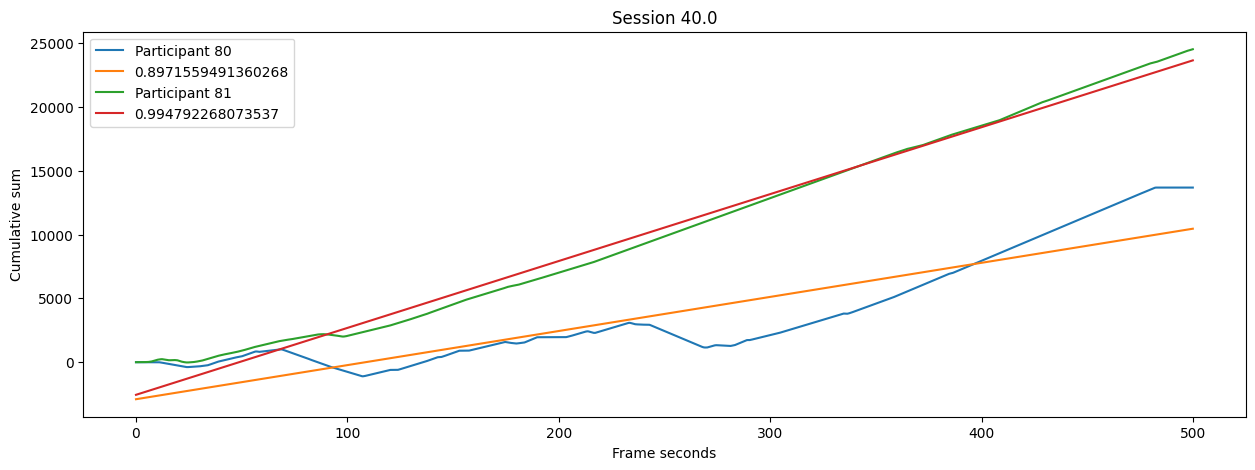

3352 3352
3352 3352


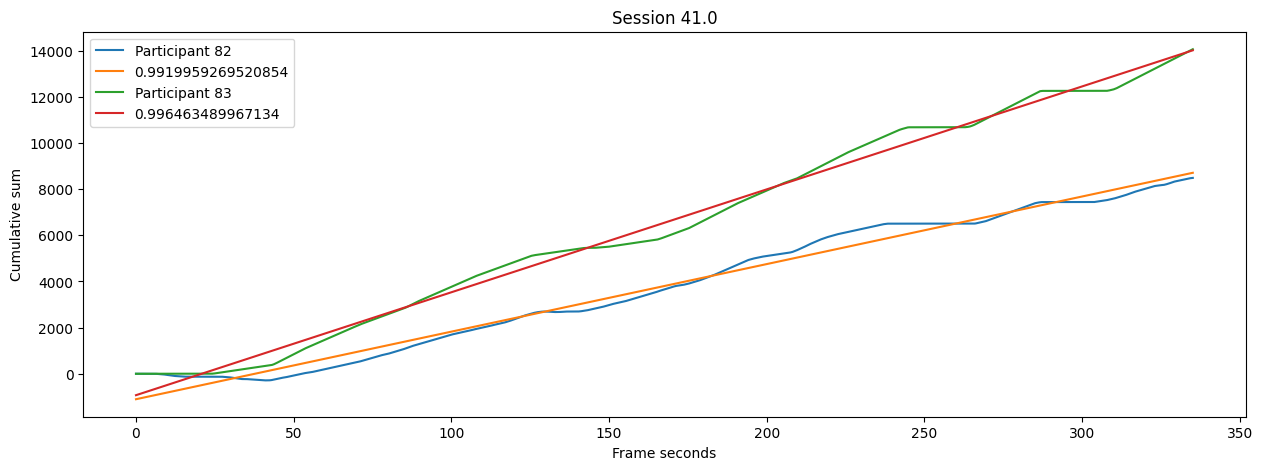

[list([0.2732114882506528, 0.5968929503916448])]
[list([0.2732114882506528, 0.5968929503916448])]
[list([0.0691051007442367, 0.16873298239244874])]
[list([0.0691051007442367, 0.16873298239244874])]
[list([0.5312322140011383, 0.3552504268639727])]
[list([0.5312322140011383, 0.3552504268639727])]
[list([0.6686730024639211, 0.6463217177050335])]
[list([0.6686730024639211, 0.6463217177050335])]
[list([0.1557123394316855, 0.30404826780848576])]
[list([0.1557123394316855, 0.30404826780848576])]
[list([0.3359415949082741, 0.6383564208161738])]
[list([0.3359415949082741, 0.6383564208161738])]
[list([0.3220434131736527, 0.32834955089820367])]
[list([0.3220434131736527, 0.32834955089820367])]
[list([0.4402918287937742, 0.5368774319066147])]
[list([0.4402918287937742, 0.5368774319066147])]
[list([0.16032717282717285, 0.4494380619380619])]
[list([0.16032717282717285, 0.4494380619380619])]
[list([0.6098581839669096, 0.5162005121134529])]
[list([0.6098581839669096, 0.5162005121134529])]
[list([0.594

,session,mse,corr,abs_diff,cohen_kappa,valuesum,interpersonal_list,interpersonal_diff,agreeable_general_sum,likingscale_sum,...,openness,religiousness,political,agreeable_general,relationalc,likingscale,slopes,r_values,p_values,slope_diff
0,3.0,24.471018,0.087866,4.620714,0.006817,4.610966,"[0.2732114882506528, 0.5968929503916448]",0.323681,13.0,12.428571,...,"[7, 10]","[nan, nan]","[nan, nan]","[6, 7]","[nan, nan]","[6.142857142857143, 6.285714285714286]","[11.546675082852992, 59.12031511944059]","[0.9505919851162745, 0.9998317371766013]","[0.0, 0.0]",47.573640
1,4.0,0.299147,-0.002742,0.296243,-0.080889,0.107097,"[0.0691051007442367, 0.16873298239244874]",0.099628,11.0,8.714286,...,"[9, 5]","[4.0, 2.0]","[6.0, 5.0]","[5, 6]","[nan, nan]","[4.428571428571429, 4.285714285714286]","[2.0662432921629383, 0.9500046990341464]","[0.9036017016113977, 0.9144213964237842]","[0.0, 0.0]",1.116239
2,5.0,11.212863,0.468733,2.393284,0.125069,2.250996,"[0.5312322140011383, 0.3552504268639727]",0.175982,14.0,12.142857,...,"[5, 10]","[4.0, 6.0]","[6.0, 1.0]","[7, 7]","[nan, nan]","[5.142857142857143, 7.0]","[53.39627886869458, 33.13563212720864]","[0.9946208561589281, 0.9776278491887526]","[0.0, 0.0]",20.260647
3,14.0,0.350933,0.850446,0.336149,0.234881,0.223513,"[0.6686730024639211, 0.6463217177050335]",0.022351,14.0,12.714286,...,"[10, 9]","[1.0, 6.0]","[7.0, 3.0]","[7, 7]","[nan, nan]","[6.142857142857143, 6.571428571428571]","[69.2279609272721, 66.03967669710188]","[0.9998001797941015, 0.9998224800482711]","[0.0, 0.0]",3.188284
4,22.0,4.255158,0.035704,1.652978,-0.017212,0.447061,"[0.1557123394316855, 0.30404826780848576]",0.148336,9.0,8.142857,...,"[5, 5]","[2.0, 7.0]","[7.0, 2.0]","[5, 4]","[nan, nan]","[3.4285714285714284, 4.714285714285714]","[3.710062133157968, -4.072823715623164]","[0.9047852758066713, -0.6934582048564152]","[0.0, 0.0]",7.782886
5,25.0,11.098091,0.711805,3.237739,-0.031465,3.142643,"[0.3359415949082741, 0.6383564208161738]",0.302415,14.0,12.142857,...,"[8, 7]","[2.0, 4.0]","[5.0, 1.0]","[7, 7]","[nan, nan]","[5.714285714285714, 6.428571428571429]","[36.0521195157531, 67.72625119582383]","[0.9935158177181616, 0.9989414876878697]","[0.0, 0.0]",31.674132
6,26.0,11.90756,0.21407,2.633982,0.03543,0.578967,"[0.3220434131736527, 0.32834955089820367]",0.006306,8.0,4.571429,...,"[6, 7]","[1.0, 7.0]","[7.0, 1.0]","[5, 3]","[nan, nan]","[2.7142857142857144, 1.8571428571428572]","[17.997734330188198, 11.089268000666507]","[0.9939867661723076, 0.7983539629155393]","[0.0, 0.0]",6.908466
7,32.0,12.696498,0.076485,2.68716,0.044338,0.172374,"[0.4402918287937742, 0.5368774319066147]",0.096586,13.0,11.285714,...,"[9, 10]","[1.0, 6.0]","[6.0, 2.0]","[6, 7]","[nan, nan]","[4.428571428571429, 6.857142857142857]","[34.08639644190642, 38.10195552070124]","[0.9748451086066359, 0.9970683306714984]","[0.0, 0.0]",4.015559
8,38.0,21.8499,-0.094086,4.22952,0.029343,4.18007,"[0.16032717282717285, 0.4494380619380619]",0.289111,11.0,10.857143,...,"[10, 5]","[1.0, 7.0]","[7.0, 5.0]","[4, 7]","[nan, nan]","[4.857142857142857, 6.0]","[1.989143598605042, 46.07316501309489]","[0.47062635215495124, 0.9977436565754692]","[7.051910829572204e-220, 0.0]",44.084021
9,39.0,6.365373,0.482892,1.43569,0.219425,0.741974,"[0.6098581839669096, 0.5162005121134529]",0.093658,14.0,10.428571,...,"[10, 8]","[1.0, 6.0]","[6.0, 2.0]","[7, 7]","[nan, nan]","[4.571428571428571, 5.857142857142857]","[51.94308701585129, 44.37171395712274]","[0.9921327547975831, 0.9962984897587049]","[0.0, 0.0]",7.571373


In [47]:
#now, fit a linear regression to the cumulative sum of the values of each participant, and plot the values of the two participants and the regression line
#sessions
slopes = []
r_values = []
p_values = []
participant_list = []

sessions = df_interp['session'].unique()
for session in sessions:
    df_session = df_interp[df_interp['session']==session]
    #for each participant
    participants = df_session['participant_number'].unique()
    fig, ax = plt.subplots(figsize=(15,5))
    for participant in participants:
        df_participant = df_session[df_session['participant_number']==participant]
        #plot the values
        x = np.array(df_participant['frame_seconds'].values[0])
        y = np.array(df_participant['cumsum'].values[0])
        ax.plot(x,y,label = 'Participant ' + str(participant))
        #now, fit a linear regression
        slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
        line = slope*x+intercept
        print(len(line),len(x))
        slopes.append(slope)
        r_values.append(r_value)
        p_values.append(p_value)
        participant_list.append(participant)
        ax.plot(x,line,label = str(r_value))

    #add title and legend
    ax.set_title('Session ' + str(session))
    ax.legend()
    ax.set_xlabel('Frame seconds')
    ax.set_ylabel('Cumulative sum')
    plt.show()


#add to df_disagreement
df_disagreement['slopes'] = [i for i in np.array(slopes).reshape(int(len(slopes)/2), 2)]
df_disagreement['r_values'] = [i for i in np.array(r_values).reshape(int(len(slopes)/2), 2)]
df_disagreement['p_values'] = [i for i in np.array(p_values).reshape(int(len(slopes)/2), 2)]

df_disagreement['slope_diff'] = np.abs(df_disagreement['slopes'].apply(lambda x: x[0])-df_disagreement['slopes'].apply(lambda x: x[1]))

#now, add slopes to df_midq, according to the participant number
for participant in participant_list:
    df_midq.loc[df_midq['participant']==participant,'slope'] = slopes[participant_list.index(participant)]
    #add also the values in the df_disagreement['interpersonal_list']
    session = df_midq[df_midq['participant']==participant]['session'].values[0]
    interpersonal_list = df_disagreement[df_disagreement['session']==session]['interpersonal_list'].values

    #check if participant number is even or odd
    if participant%2==0:
        df_midq.loc[df_midq['participant']==participant,'interpersonal'] = interpersonal_list[0][0]
    else:
        df_midq.loc[df_midq['participant']==participant,'interpersonal'] = interpersonal_list[0][1]

#save df_disagreement
df_disagreement.to_pickle('./dataframes/df_disagreement1dec.pkl')
#to csv
df_disagreement.to_csv('./dataframes/df_disagreement1dec.csv')

#save df_midq
df_midq.to_pickle('./dataframes/midq_processed.pkl')
#to csv
df_midq.to_csv('./dataframes/midq_processed.csv')

df_disagreement
    




In [32]:
r_values =np.array([0.95059199, 0.99983174, 0.9036017, 0.9144214, 0.99462086, 0.97762785, 0.99980018, 0.99982248, 
                    0.90478528, -0.6934582, 0.99351582, 0.99894149, 0.99398677, 0.79835396, 0.97484511, 0.99706833,
                      0.47062635, 0.99774366, 0.99213275, 0.99629849, 0.89715595, 0.99479227, 0.99199593, 0.99646349])
print(np.mean(r_values))
print(np.std(r_values))

0.87689856875
0.34551519505857153


In [41]:
#now, use pearson correlation to find which variables better correlate with the slope difference
df_disagreement_numeric = df_disagreement[cols_oi].astype(float)
df_corr = df_disagreement_numeric.corr(method='pearson')
pval = df_disagreement_numeric.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*df_corr.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
df_corr_pval = df_corr.round(2).astype(str) + p
df_corr_pval

,mse,corr,abs_diff,cohen_kappa,valuesum,interpersonal_diff,agreeable_general_sum,likingscale_sum,extraversion_diff,agreeableness_diff,conscientiousness_diff,neuroticism_diff,openness_diff,religiousness_diff,political_diff,agreeable_general_diff,likingscale_diff,slope_diff
mse,1.0***,-0.35,0.94***,-0.19,0.8**,0.55,-0.14,-0.0,0.13,0.39,-0.05,-0.14,0.18,-0.09,0.08,0.61*,0.24,0.84***
corr,-0.35,1.0***,-0.31,0.63*,-0.1,-0.24,0.58*,0.35,0.09,-0.53,-0.07,0.07,-0.16,-0.14,0.24,-0.47,0.01,-0.15
abs_diff,0.94***,-0.31,1.0***,-0.3,0.85***,0.7*,-0.06,0.1,0.16,0.41,0.11,0.07,0.17,0.05,0.14,0.42,0.15,0.87***
cohen_kappa,-0.19,0.63*,-0.3,1.0***,-0.21,-0.44,0.47,0.28,0.24,0.02,-0.25,-0.04,-0.03,0.25,0.28,-0.26,0.24,-0.23
valuesum,0.8**,-0.1,0.85***,-0.21,1.0***,0.86***,0.18,0.36,0.11,0.15,-0.08,0.06,0.43,-0.17,-0.19,0.25,-0.14,0.99***
interpersonal_diff,0.55,-0.24,0.7*,-0.44,0.86***,1.0***,0.27,0.51,0.09,0.21,-0.06,0.09,0.37,-0.16,-0.3,-0.05,-0.25,0.84***
agreeable_general_sum,-0.14,0.58*,-0.06,0.47,0.18,0.27,1.0***,0.9***,0.5,0.02,-0.34,-0.16,0.3,-0.09,-0.19,-0.7*,-0.05,0.11
likingscale_sum,-0.0,0.35,0.1,0.28,0.36,0.51,0.9***,1.0***,0.52,0.1,-0.35,-0.24,0.35,-0.01,-0.28,-0.6*,-0.15,0.31
extraversion_diff,0.13,0.09,0.16,0.24,0.11,0.09,0.5,0.52,1.0***,0.31,0.19,-0.24,0.31,0.07,0.25,-0.42,0.03,0.05
agreeableness_diff,0.39,-0.53,0.41,0.02,0.15,0.21,0.02,0.1,0.31,1.0***,-0.05,0.1,0.15,0.47,0.01,0.11,0.13,0.16


<AxesSubplot: >

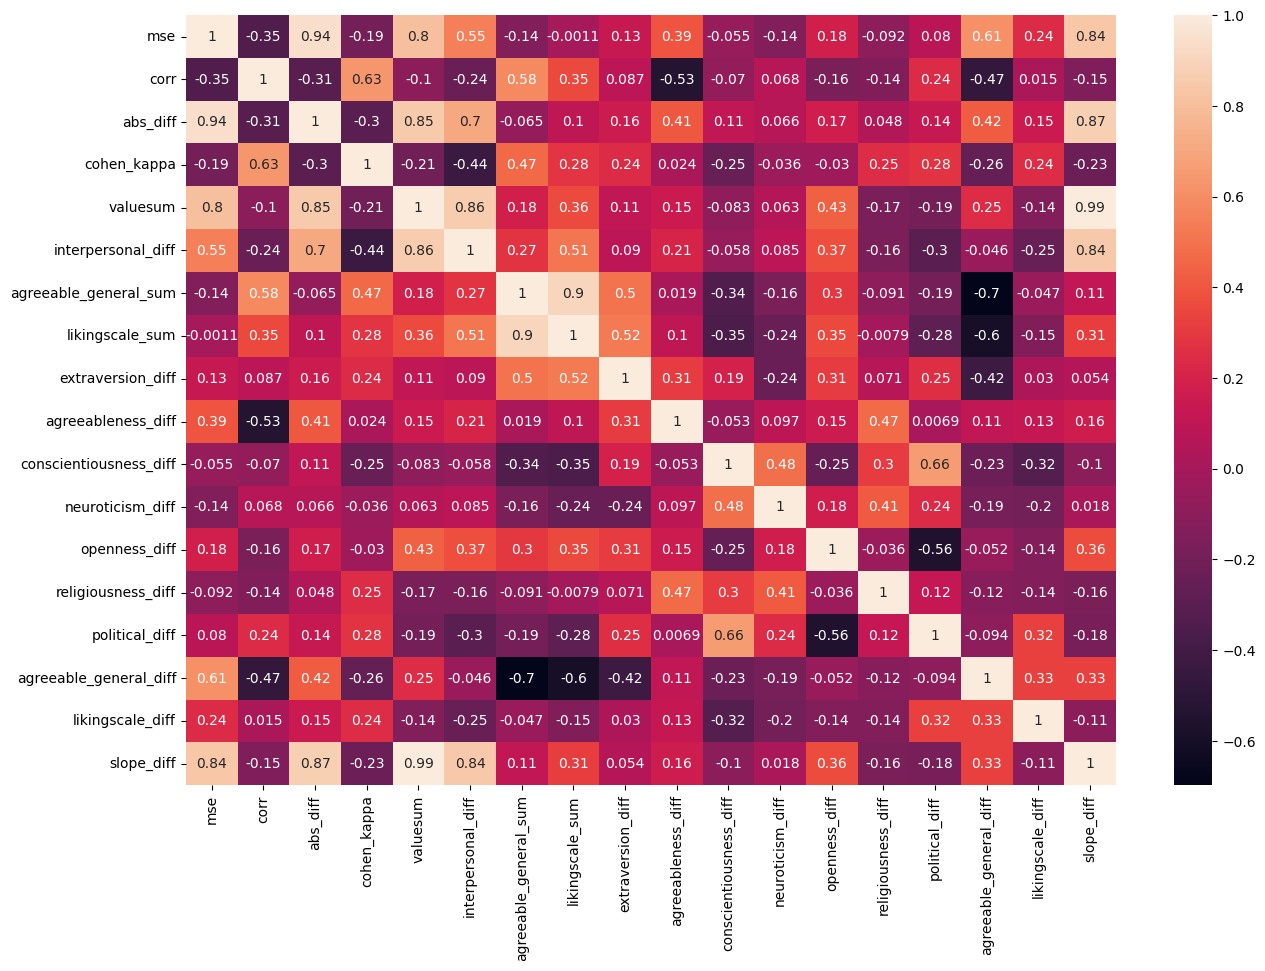

In [42]:
#plot df_corr as a correlation matrix
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(df_corr, annot=True, ax=ax)


In [58]:
#print participant demographics
#avg age + std
df_midq['age'] = df_midq['age'].astype(float)
print('Average age: ',df_midq['age'].mean(), ' +- ', df_midq['age'].std())
#age range
print('Age range: ',df_midq['age'].min(), ' - ', df_midq['age'].max())
#gender distribution - count occurrences of every value
print( df_midq['gender'].value_counts())
#race distribution
print(df_midq['race'].value_counts())
print(df_midq['proficiency'].value_counts())
df_midq

Average age:  39.75  +-  13.49154324495292
Age range:  20.0  -  61.0
Female    13
Male      11
Name: gender, dtype: int64
Caucasian/European American/White                                                                        15
Asian/Asian American                                                                                      4
Hispanic/Latino/Latina/Latinx/Latine                                                                      2
African/African American/Black                                                                            1
African/African American/Black,Caucasian/European American/White,Hispanic/Latino/Latina/Latinx/Latine     1
Caucasian/European American/White,Hispanic/Latino/Latina/Latinx/Latine                                    1
Name: race, dtype: int64
Native speaker     21
Proficient User     3
Name: proficiency, dtype: int64


,participant,session,age,gender,nationality,race,proficiency,extraversion,agreeableness,conscientiousness,neuroticism,openness,religiousness,political,agreeable_general,relationalc,likingscale,slope,interpersonal
0,6,3.0,30.0,Male,German,Caucasian/European American/White,Proficient User,8,7,9,6,7,NaN,NaN,6,NaN,6.142857,11.546675,0.273211
1,7,3.0,38.0,Male,Taiwan,Asian/Asian American,Proficient User,4,10,6,7,10,NaN,NaN,7,NaN,6.285714,59.120315,0.596893
2,8,4.0,20.0,Female,Chinese,Asian/Asian American,Native speaker,6,7,6,8,9,4.0,6.0,5,NaN,4.428571,2.066243,0.069105
3,9,4.0,21.0,Male,American,African/African American/Black,Native speaker,5,6,5,6,5,2.0,5.0,6,NaN,4.285714,0.950005,0.168733
4,10,5.0,34.0,Female,Colombian,Hispanic/Latino/Latina/Latinx/Latine,Native speaker,5,9,8,6,5,4.0,6.0,7,NaN,5.142857,53.396279,0.531232
5,11,5.0,55.0,Female,American,Caucasian/European American/White,Native speaker,10,7,10,2,10,6.0,1.0,7,NaN,7.000000,33.135632,0.355250
6,28,14.0,58.0,Female,United States,Caucasian/European American/White,Native speaker,8,8,10,5,10,1.0,7.0,7,NaN,6.142857,69.227961,0.668673
7,29,14.0,33.0,Female,American,Caucasian/European American/White,Native speaker,5,7,9,6,9,6.0,3.0,7,NaN,6.571429,66.039677,0.646322
8,44,22.0,31.0,Male,American,Caucasian/European American/White,Native speaker,6,3,7,6,5,2.0,7.0,5,NaN,3.428571,3.710062,0.155712
9,45,22.0,46.0,Male,American,Caucasian/European American/White,Native speaker,6,2,4,2,5,7.0,2.0,4,NaN,4.714286,-4.072824,0.304048


In [50]:
cols_midq = ['extraversion', 'agreeableness', 'conscientiousness',
       'neuroticism', 'openness', 'religiousness', 'political',
       'agreeable_general', 'relationalc', 'likingscale', 'interpersonal','slope']

#get correlation matrix
df_midq_numeric = df_midq[cols_midq].astype(float)
df_corr = df_midq_numeric.corr(method='pearson')
pval = df_midq_numeric.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*df_corr.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
df_corr_pval = df_corr.round(2).astype(str) + p
df_corr_pval

,extraversion,agreeableness,conscientiousness,neuroticism,openness,religiousness,political,agreeable_general,relationalc,likingscale,interpersonal,slope
extraversion,1.0***,0.03,0.37,-0.46*,0.36,0.13,-0.23,0.19,nan,0.35,0.2,0.14
agreeableness,0.03,1.0***,0.42*,-0.05,0.44*,-0.24,-0.09,0.21,nan,0.2,0.31,0.42*
conscientiousness,0.37,0.42*,1.0***,-0.17,0.35,-0.02,-0.21,0.36,nan,0.48*,0.39,0.51*
neuroticism,-0.46*,-0.05,-0.17,1.0***,0.04,-0.57**,0.56**,0.1,nan,-0.04,-0.2,-0.05
openness,0.36,0.44*,0.35,0.04,1.0***,-0.07,0.02,0.17,nan,0.26,0.3,0.3
religiousness,0.13,-0.24,-0.02,-0.57**,-0.07,1.0***,-0.54**,0.08,nan,0.27,-0.0,-0.02
political,-0.23,-0.09,-0.21,0.56**,0.02,-0.54**,1.0***,-0.15,nan,-0.32,-0.28,-0.21
agreeable_general,0.19,0.21,0.36,0.1,0.17,0.08,-0.15,1.0***,nan,0.79***,0.46*,0.72***
relationalc,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
likingscale,0.35,0.2,0.48*,-0.04,0.26,0.27,-0.32,0.79***,nan,1.0***,0.34,0.54**


<AxesSubplot: >

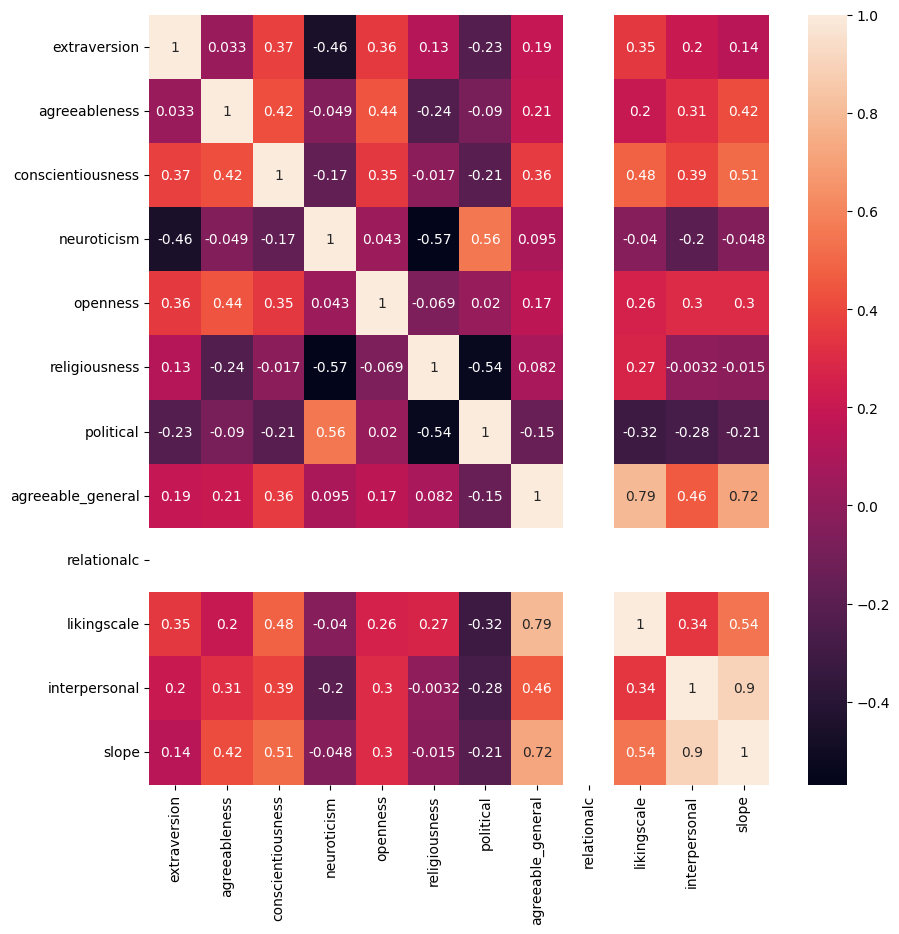

In [51]:
#plot
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df_corr, annot=True, ax=ax)
